In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

with_shrub_path = 'C:/Users/allen/OneDrive/Desktop/Work/Scripts/Tree Segmentation/output/with_shrub/'
without_shrub_path = 'C:/Users/allen/OneDrive/Desktop/Work/Scripts/Tree Segmentation/output/without_shrub/'
root_path = 'C:/Users/allen/OneDrive/Desktop/Work/Scripts/Tree Segmentation/output/'


app_indv = pd.read_csv("C:/Users/allen/OneDrive/Desktop/Work/data/Tree Segmentation/TEAK/NEON_struct-plant/TEAK_appindv_allyears_2022.csv")

# with_shrub_path = '/data/allen/NEON/output/with_shrub/'
# without_shrub_path = '/data/allen/NEON/output/without_shrub/'
# app_indv = pd.read_csv("TEAK_appindv_allyears_2022.csv")

# filter out saplings and stem diameter greater than 1cm
filtered_df = app_indv[app_indv['growthForm'].str.contains('sapling') == False]
filtered_df = filtered_df[(filtered_df['stemDiameter'] > 0.1) | (filtered_df['stemDiameter'].isnull())]

# set new crown diameter values according to calculated quadratic regression formula based on height
def exponential_func(x):
    return (10**0.12) * (x**0.6)

for plot_index, loc_row in filtered_df.iterrows():
    if pd.isna(loc_row['maxCrownDiameter']):
        filtered_df.at[plot_index, 'maxCrownDiameter'] = exponential_func(loc_row['height'])
    if pd.isna(loc_row['ninetyCrownDiameter']):
        filtered_df.at[plot_index, 'ninetyCrownDiameter'] = exponential_func(loc_row['height'])

# set new values and ratios
filtered_df['crown_radius'] = (filtered_df['maxCrownDiameter'] + filtered_df["ninetyCrownDiameter"])/4
filtered_df ['crown_width'] = (filtered_df ['crown_radius'] * 2)
filtered_df ['crown_depth'] = filtered_df ['height'] - filtered_df ['baseCrownHeight']
filtered_df ['crown_width/h'] = (filtered_df ['crown_radius'] * 2) / filtered_df ['height']
filtered_df ['crown_depth/h'] = (filtered_df ['height'] - filtered_df ['baseCrownHeight'])/filtered_df ['height']
filtered_df ['crown_depth/crown_width'] = (filtered_df ['height'] - filtered_df ['baseCrownHeight'])/(2 * filtered_df ['crown_radius'])

filtered_df.sort_values(by='date', ascending=False, inplace=True)
filtered_df = filtered_df.drop_duplicates(subset = 'individualID', keep = 'first')

subset = ['TEAK_043', 'TEAK_044', 'TEAK_045', 'TEAK_046', 'TEAK_047']
filtered_df = filtered_df[filtered_df['plotID'].isin(subset)]

# other dataframes
shrub_nocd_2015_df = filtered_df[filtered_df['crown_depth'].notna()]
most_recent_df = filtered_df[filtered_df['date'].str.contains('2015') == False]
shrub_stem_nona_df = most_recent_df[most_recent_df['stemDiameter'].notna()]
noshrub_df = most_recent_df[most_recent_df['growthForm'].str.contains('shrub') == False]

# more dataframes
noshrub_noheightna_df = noshrub_df[noshrub_df['height'].notna()]
noshrub_stem_nona_df = noshrub_df[noshrub_df['stemDiameter'].notna()]

# with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
#     print(noshrub_noheightna_df[['individualID', 'crown_radius', 'height']])

# Creating subplots 1x4


C:\Users\allen\AppData\Local\Temp\ipykernel_16768\2365946376.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  noshrub_noheightna_df.sort_values(by='height', inplace=True)


R2 score for existing data: 0.5895357591411761
RMSE for existing data: 0.9616801554722019


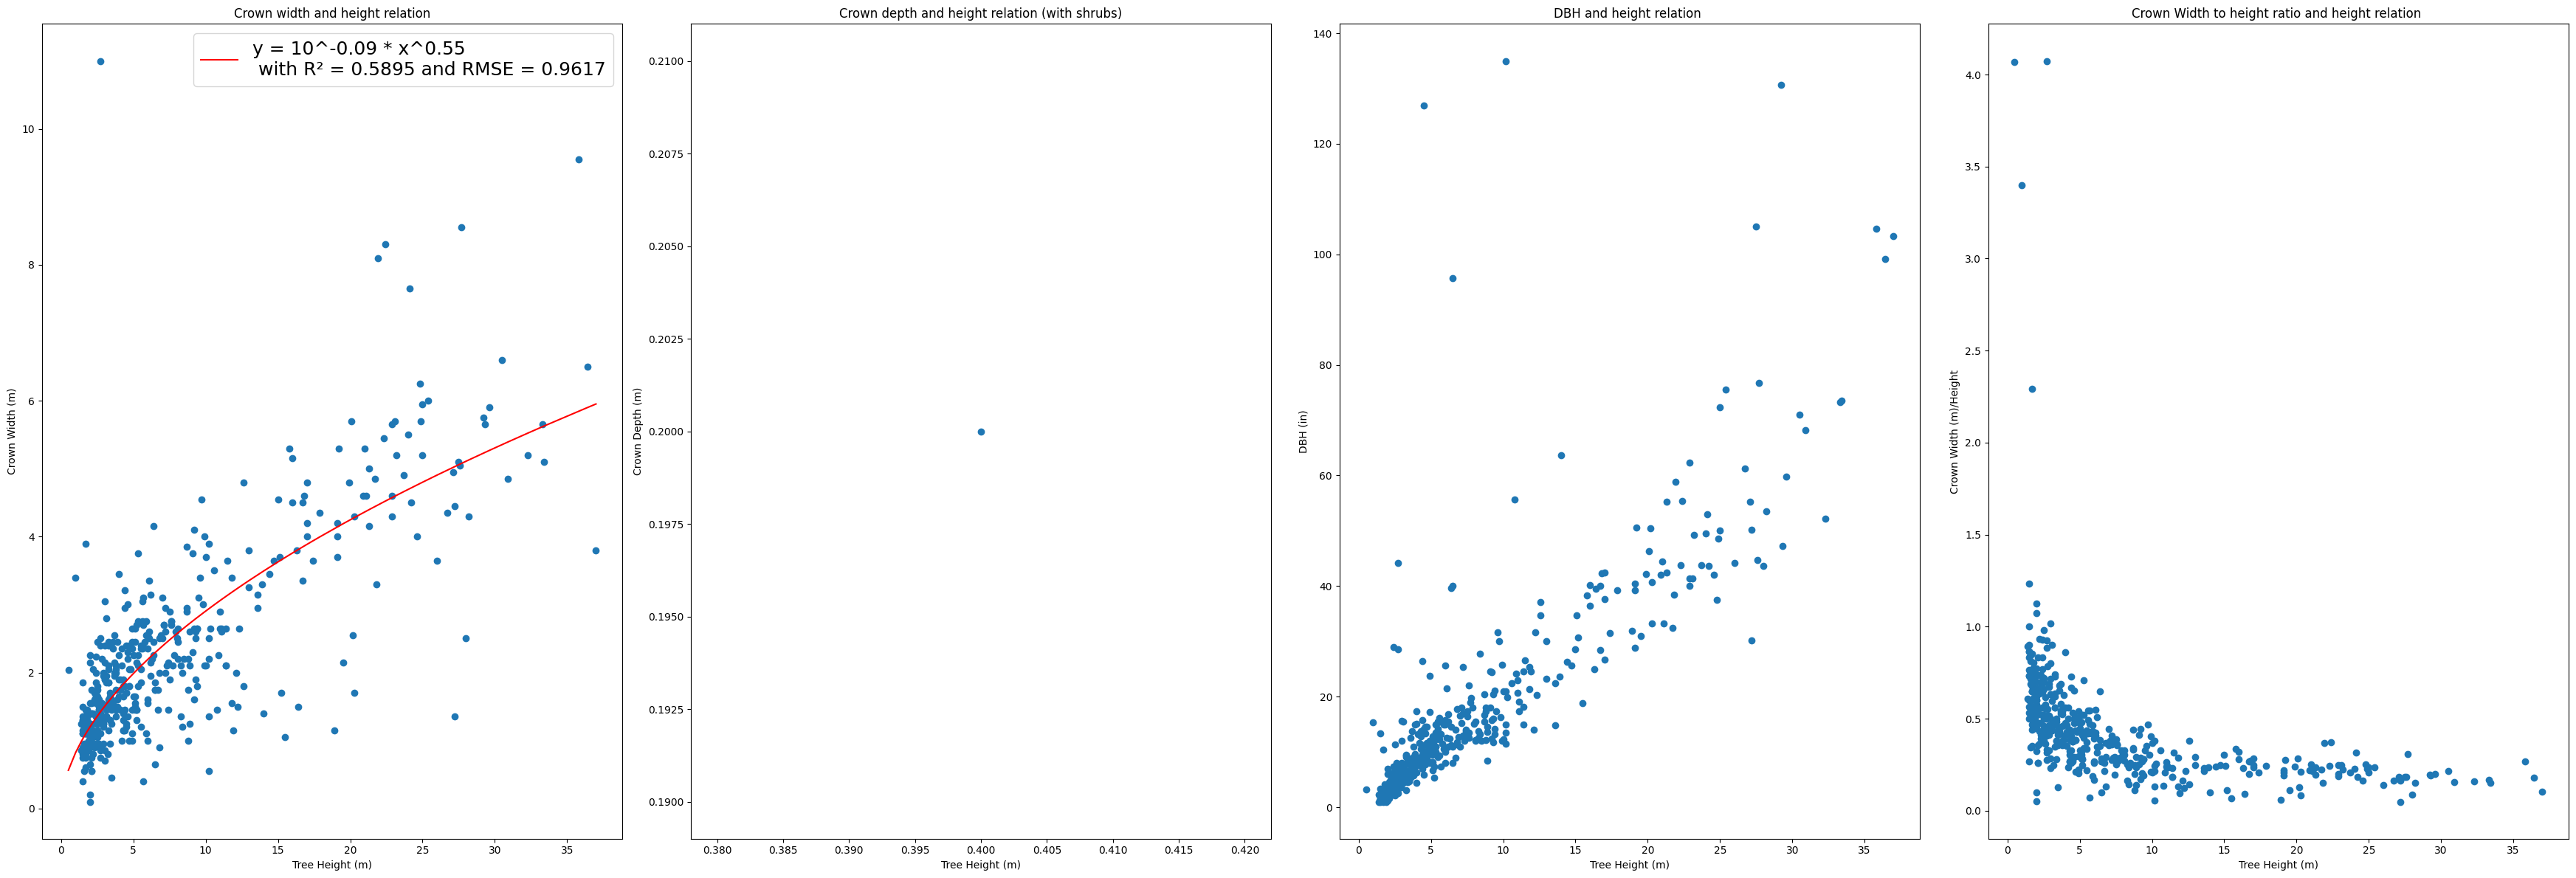

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from sklearn.metrics import mean_squared_error, r2_score

figs, axs = plt.subplots(1, 4, figsize = (35, 12))

noshrub_noheightna_df.sort_values(by='height', inplace=True)
x_existing, y_existing = noshrub_noheightna_df['height'], noshrub_noheightna_df['crown_width']

# Linear Regression Line
# m, b = np.polyfit(x1, y1, 1)
# mr = round(m, 2)
# br = round(b, 2)

# axs[0].plot(x1, m*x1 + b, color = 'red', label = f'(y = {mr}x + {br}) Regression Line')

# Quadratic Regression Line
# coefficients = np.polyfit(x1, y1, 2)
# a, b, c = coefficients

# x_curve = np.linspace(min(x1), max(x1), 100)
# y_curve = a * x_curve**2 + b* x_curve + c

# print(a, b, c)

# axs[0].plot(x_curve, y_curve, color = 'red', label = f'y = {round(a, 4)}x\u00B2 + {round(b, 2)}x + {round(c, 2)}')

# Exponential Regression Line
def exponential_func(x, a, b):
    return (10**a) * (x**b)

# Fit exponential regression model
popt, pcov = curve_fit(exponential_func, x_existing, y_existing)
a, b = popt

# Generate predicted values for x
y_pred  = exponential_func(x_existing, *popt)

# Calculate R2 and RMSE
r2 = r2_score(y_existing, y_pred)
rmse = np.sqrt(mean_squared_error(y_existing, y_pred))

print("R2 score for existing data:", r2)
print("RMSE for existing data:", rmse)

# Row 1 Plot 1
axs[0].scatter(noshrub_df['height'], noshrub_df['crown_width'])
# axs[0].plot(x_new, y_pred_new, color = 'red', label = f"10^({c:.2f} * (x^{a:.2f})) Regression")
axs[0].plot(x_existing, y_pred, color = 'red', label = f"y = 10^{a:.2f} * x^{b:.2f} \n with R\u00B2 = {r2:.4f} and RMSE = {rmse:.4f}")
axs[0].set_title('Crown width and height relation')
axs[0].set_xlabel('Tree Height (m)')
axs[0].set_ylabel('Crown Width (m)')
axs[0].legend(fontsize = '18')

# Row 1 Plot 2
axs[1].scatter(shrub_nocd_2015_df['height'], shrub_nocd_2015_df['crown_depth'])
axs[1].set_title('Crown depth and height relation (with shrubs)')
axs[1].set_xlabel('Tree Height (m)')
axs[1].set_ylabel('Crown Depth (m)')

# Row 1 Plot 3
axs[2].scatter(noshrub_df['height'], noshrub_df['stemDiameter'])
axs[2].set_title('DBH and height relation ')
axs[2].set_xlabel('Tree Height (m)')
axs[2].set_ylabel('DBH (in)')

# Row 1 Plot 4
axs[3].scatter(noshrub_df['height'], noshrub_df['crown_width/h'])
axs[3].set_title('Crown Width to height ratio and height relation ')
axs[3].set_xlabel('Tree Height (m)')
axs[3].set_ylabel('Crown Width (m)/Height')

plt.rcParams['axes.titlesize'] = 24
plt.rcParams['axes.labelsize'] = 30
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.tight_layout()

plt.savefig(root_path + 'TEAK_height_relations.png')
plt.show()

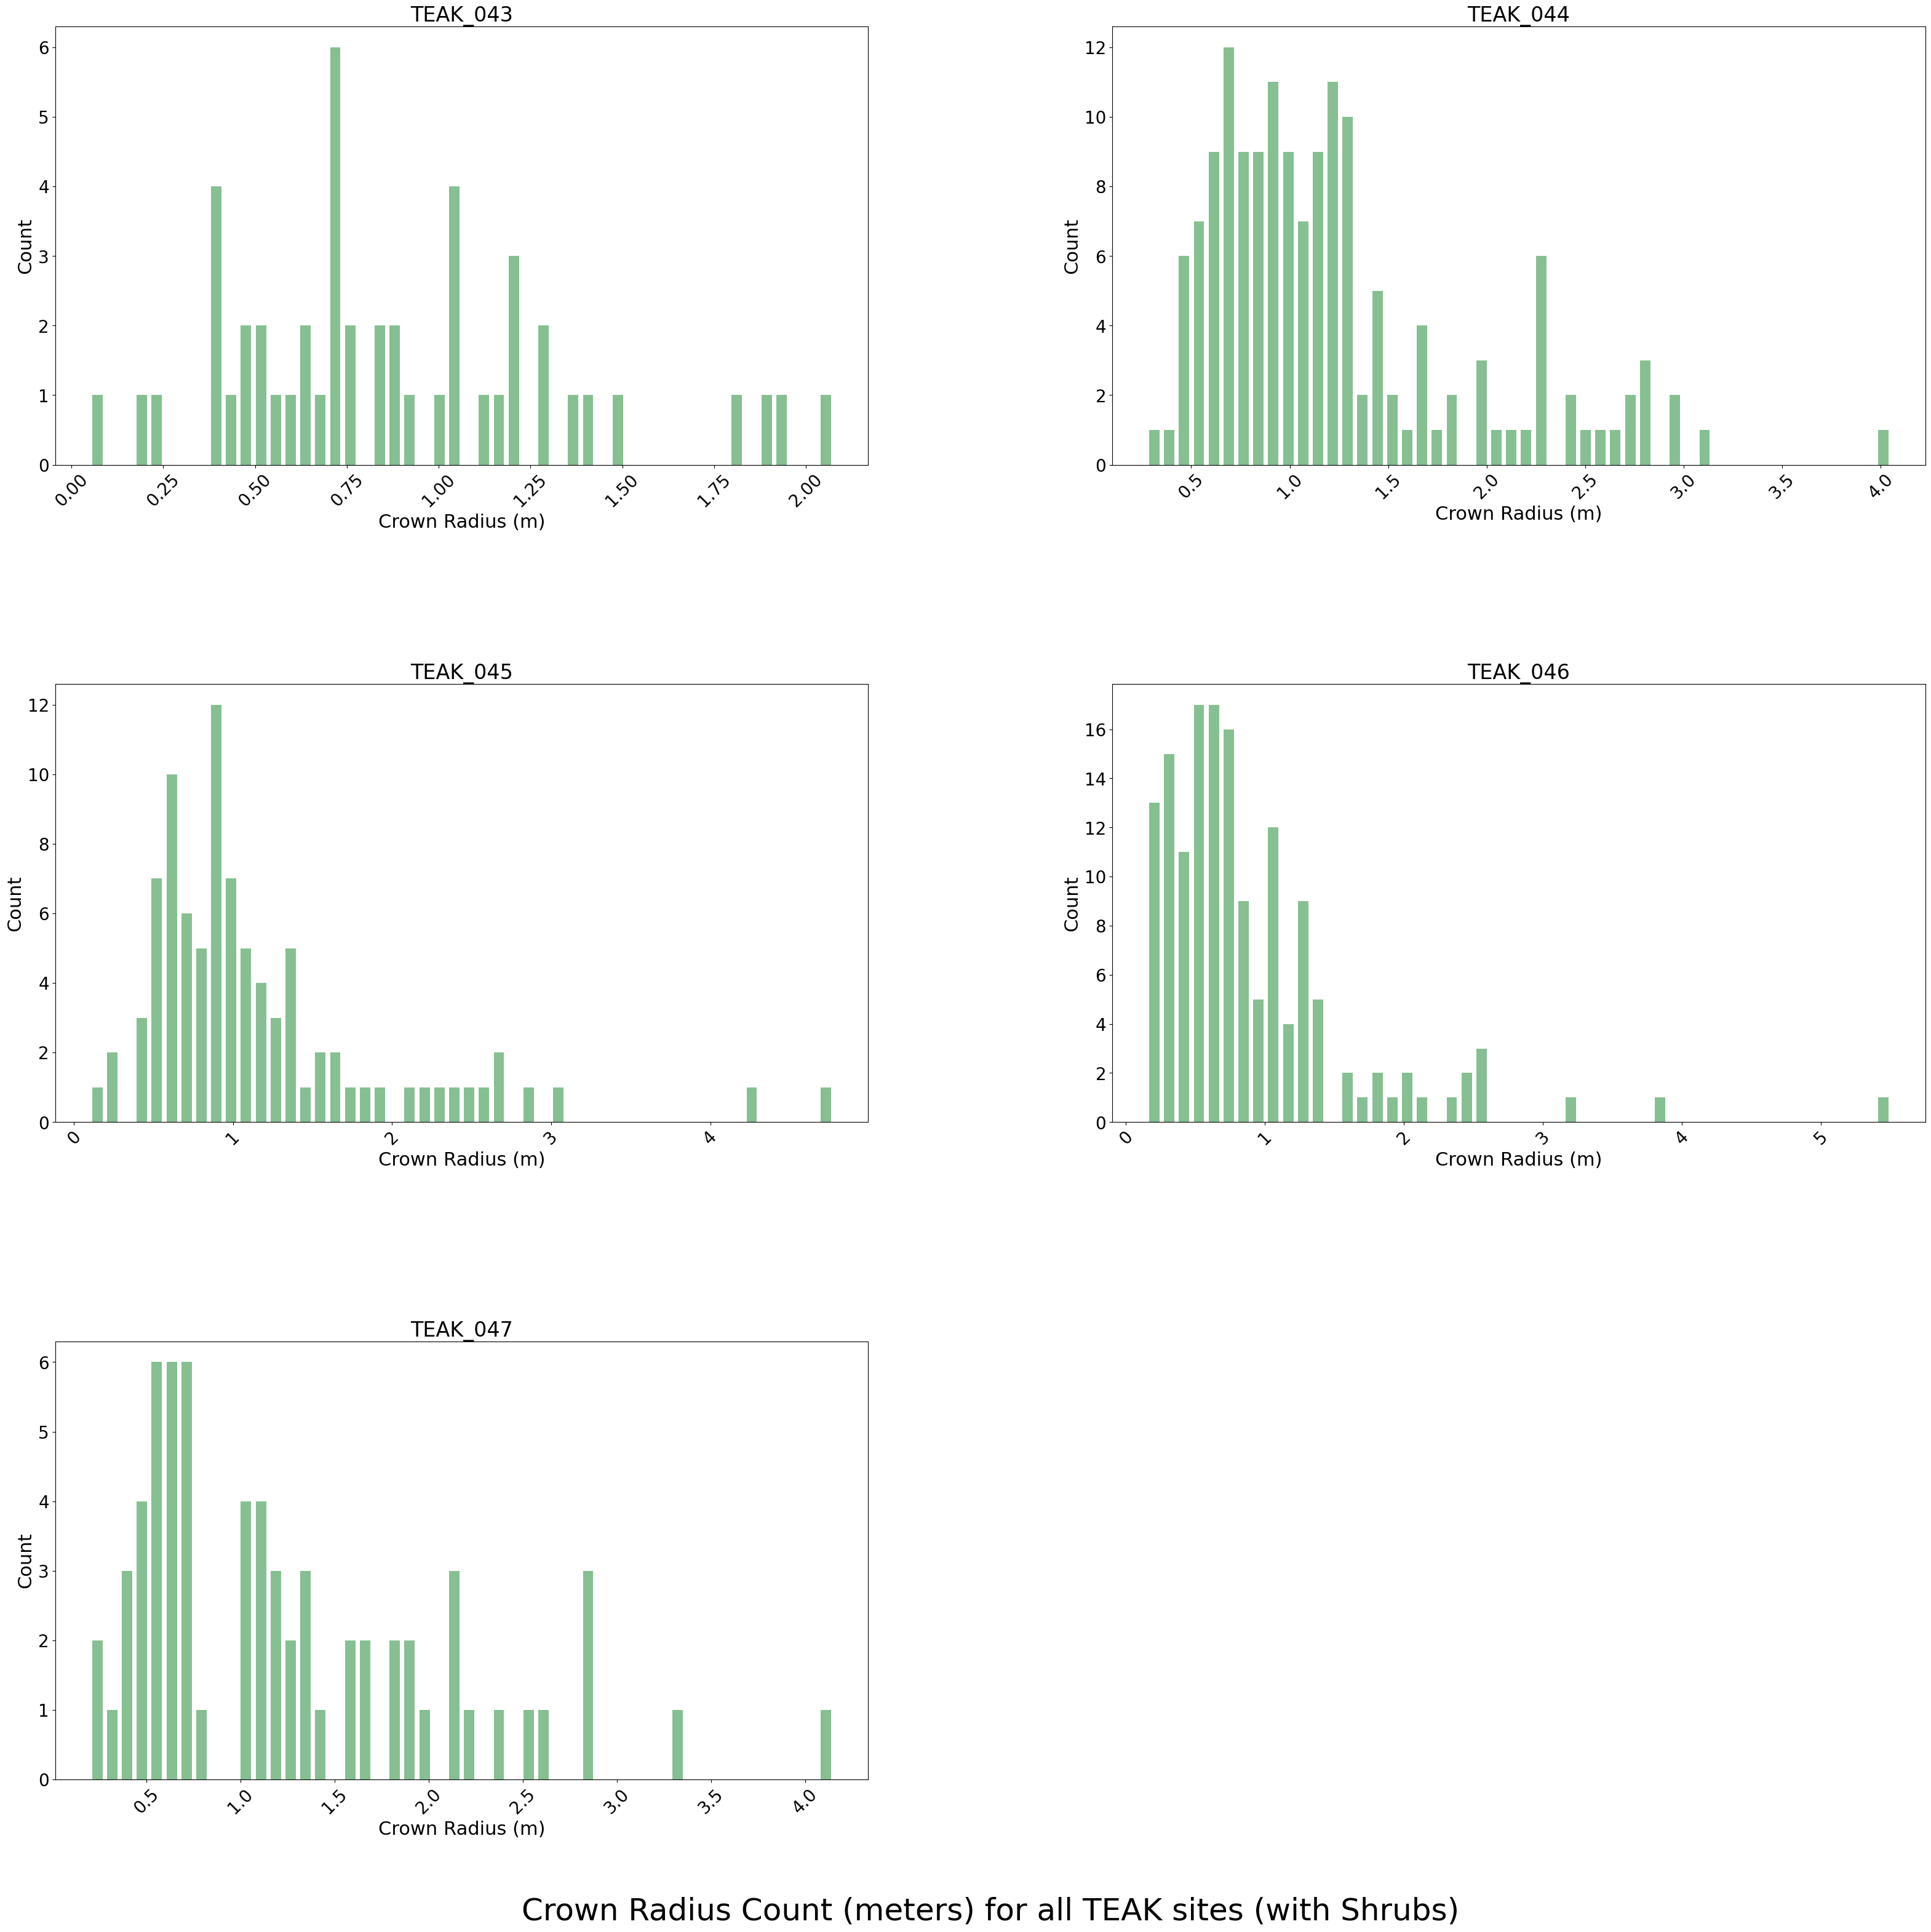

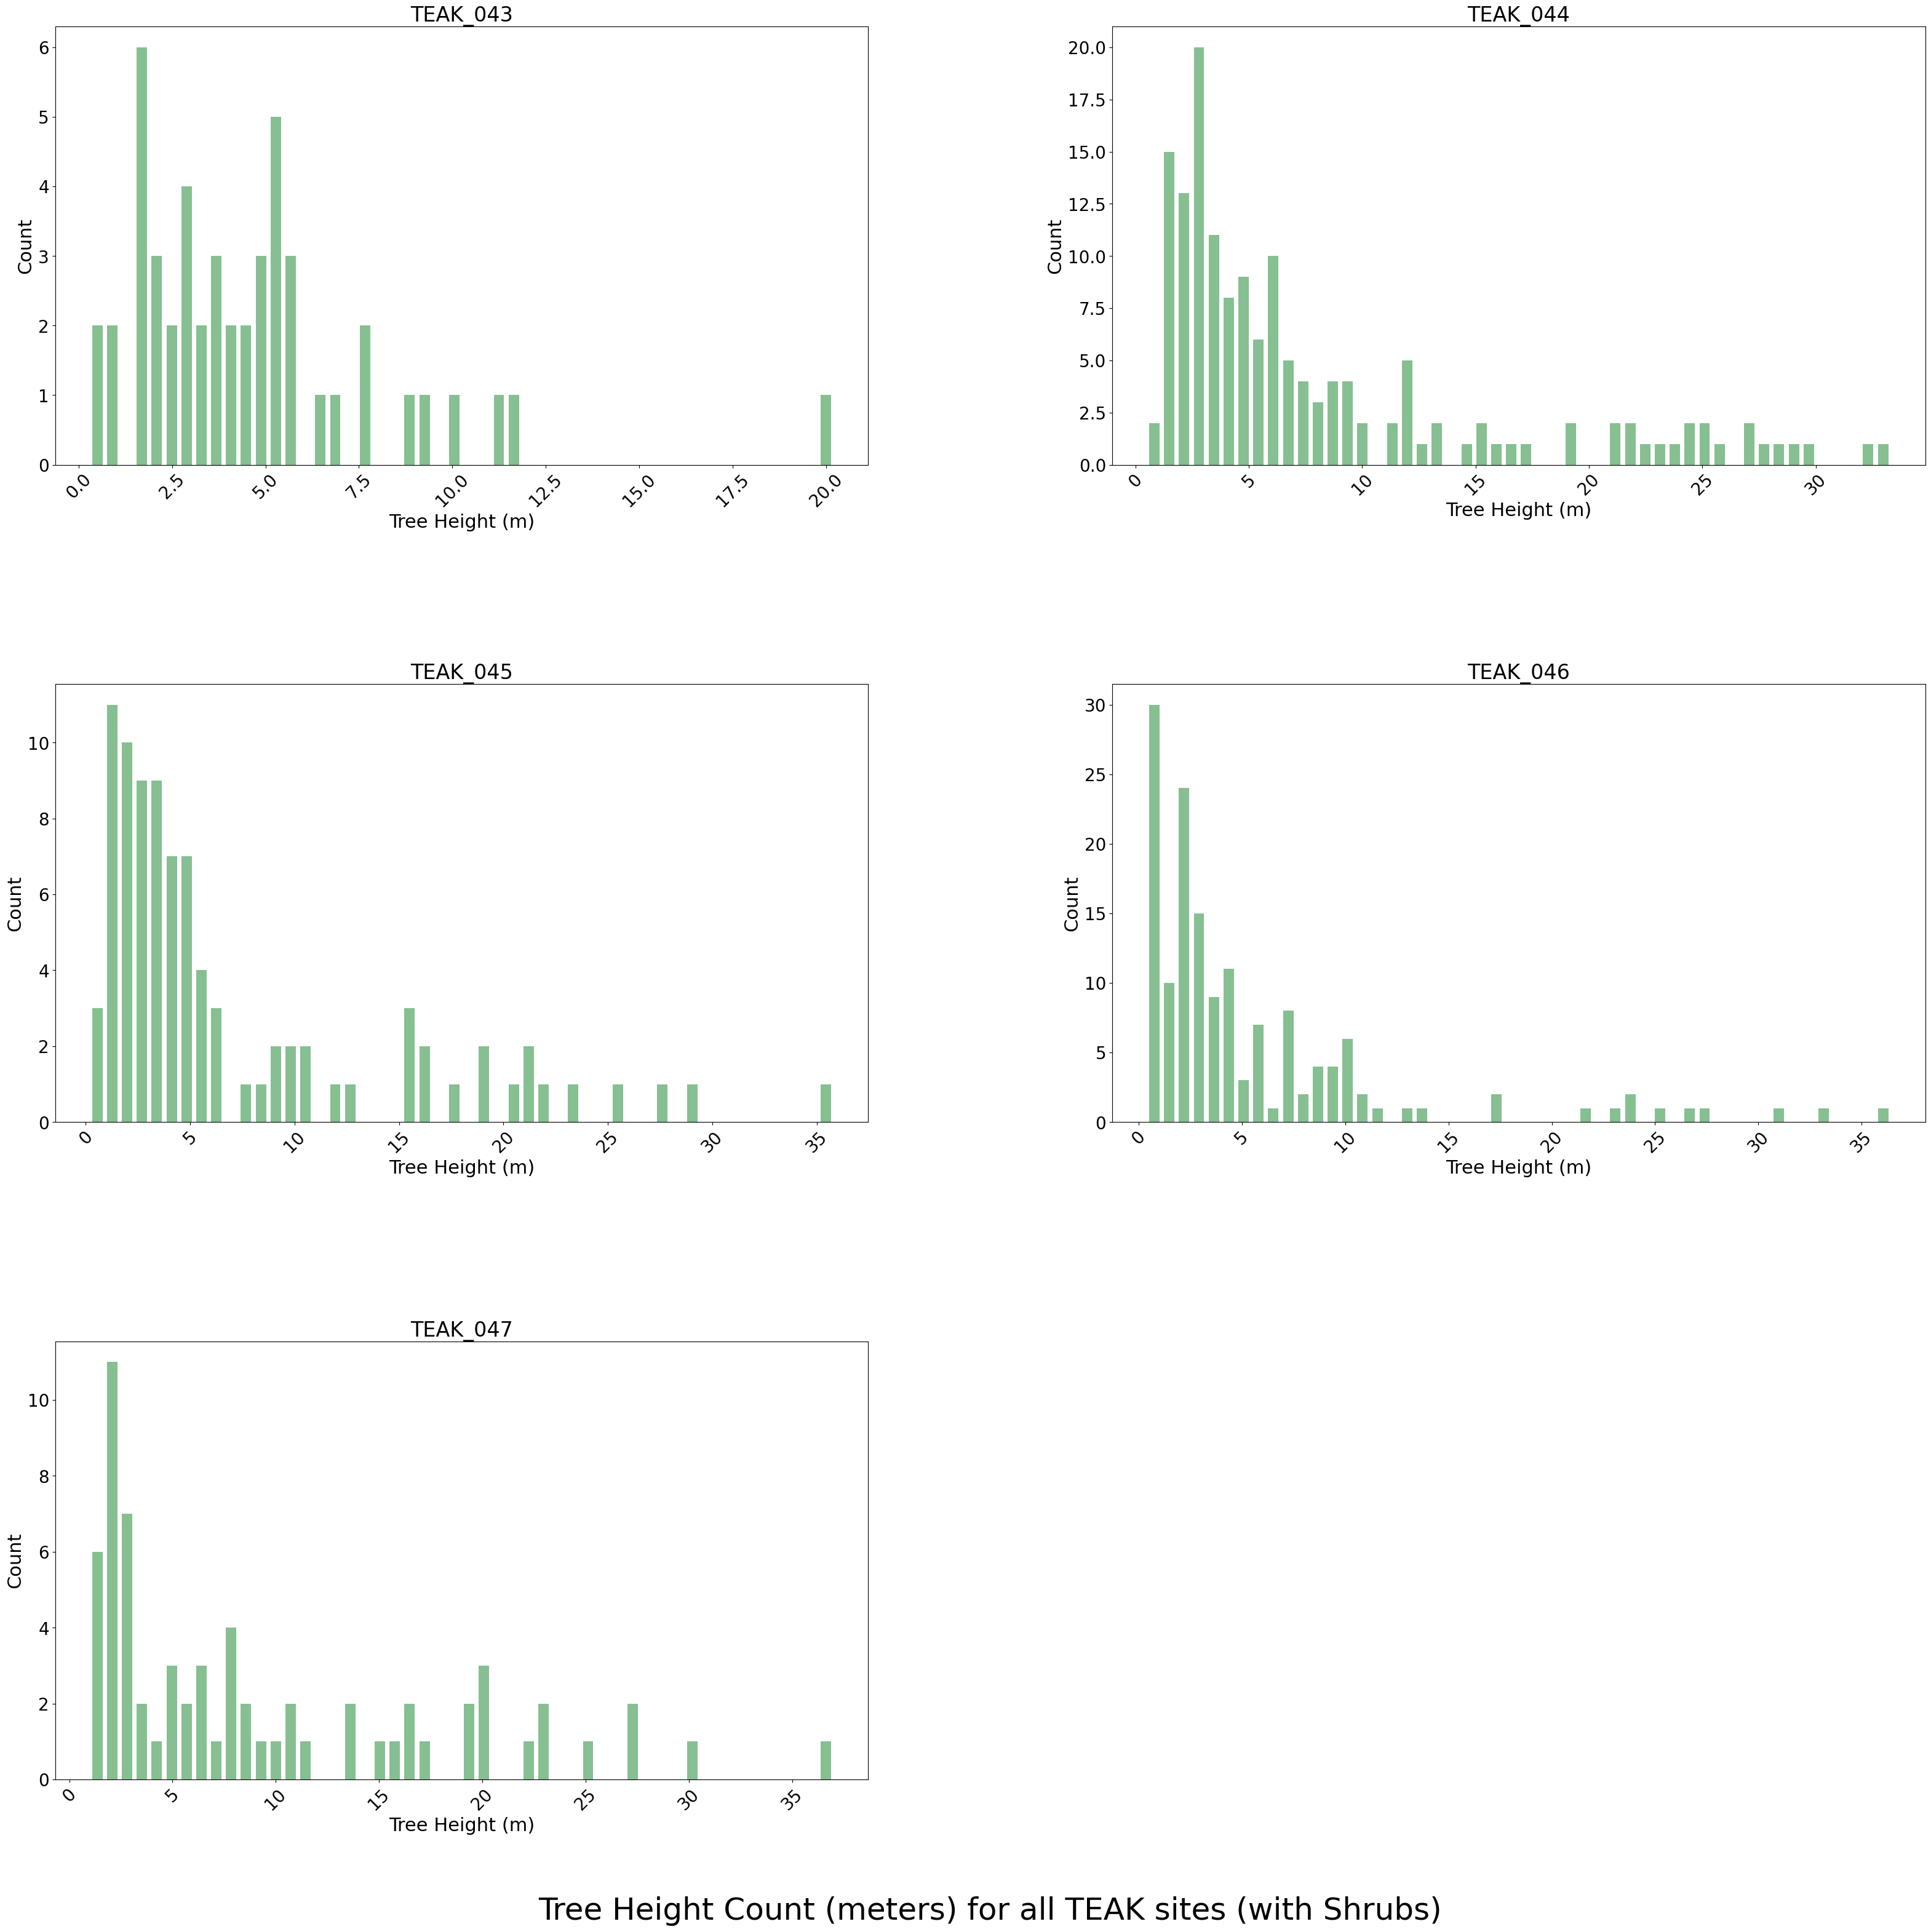

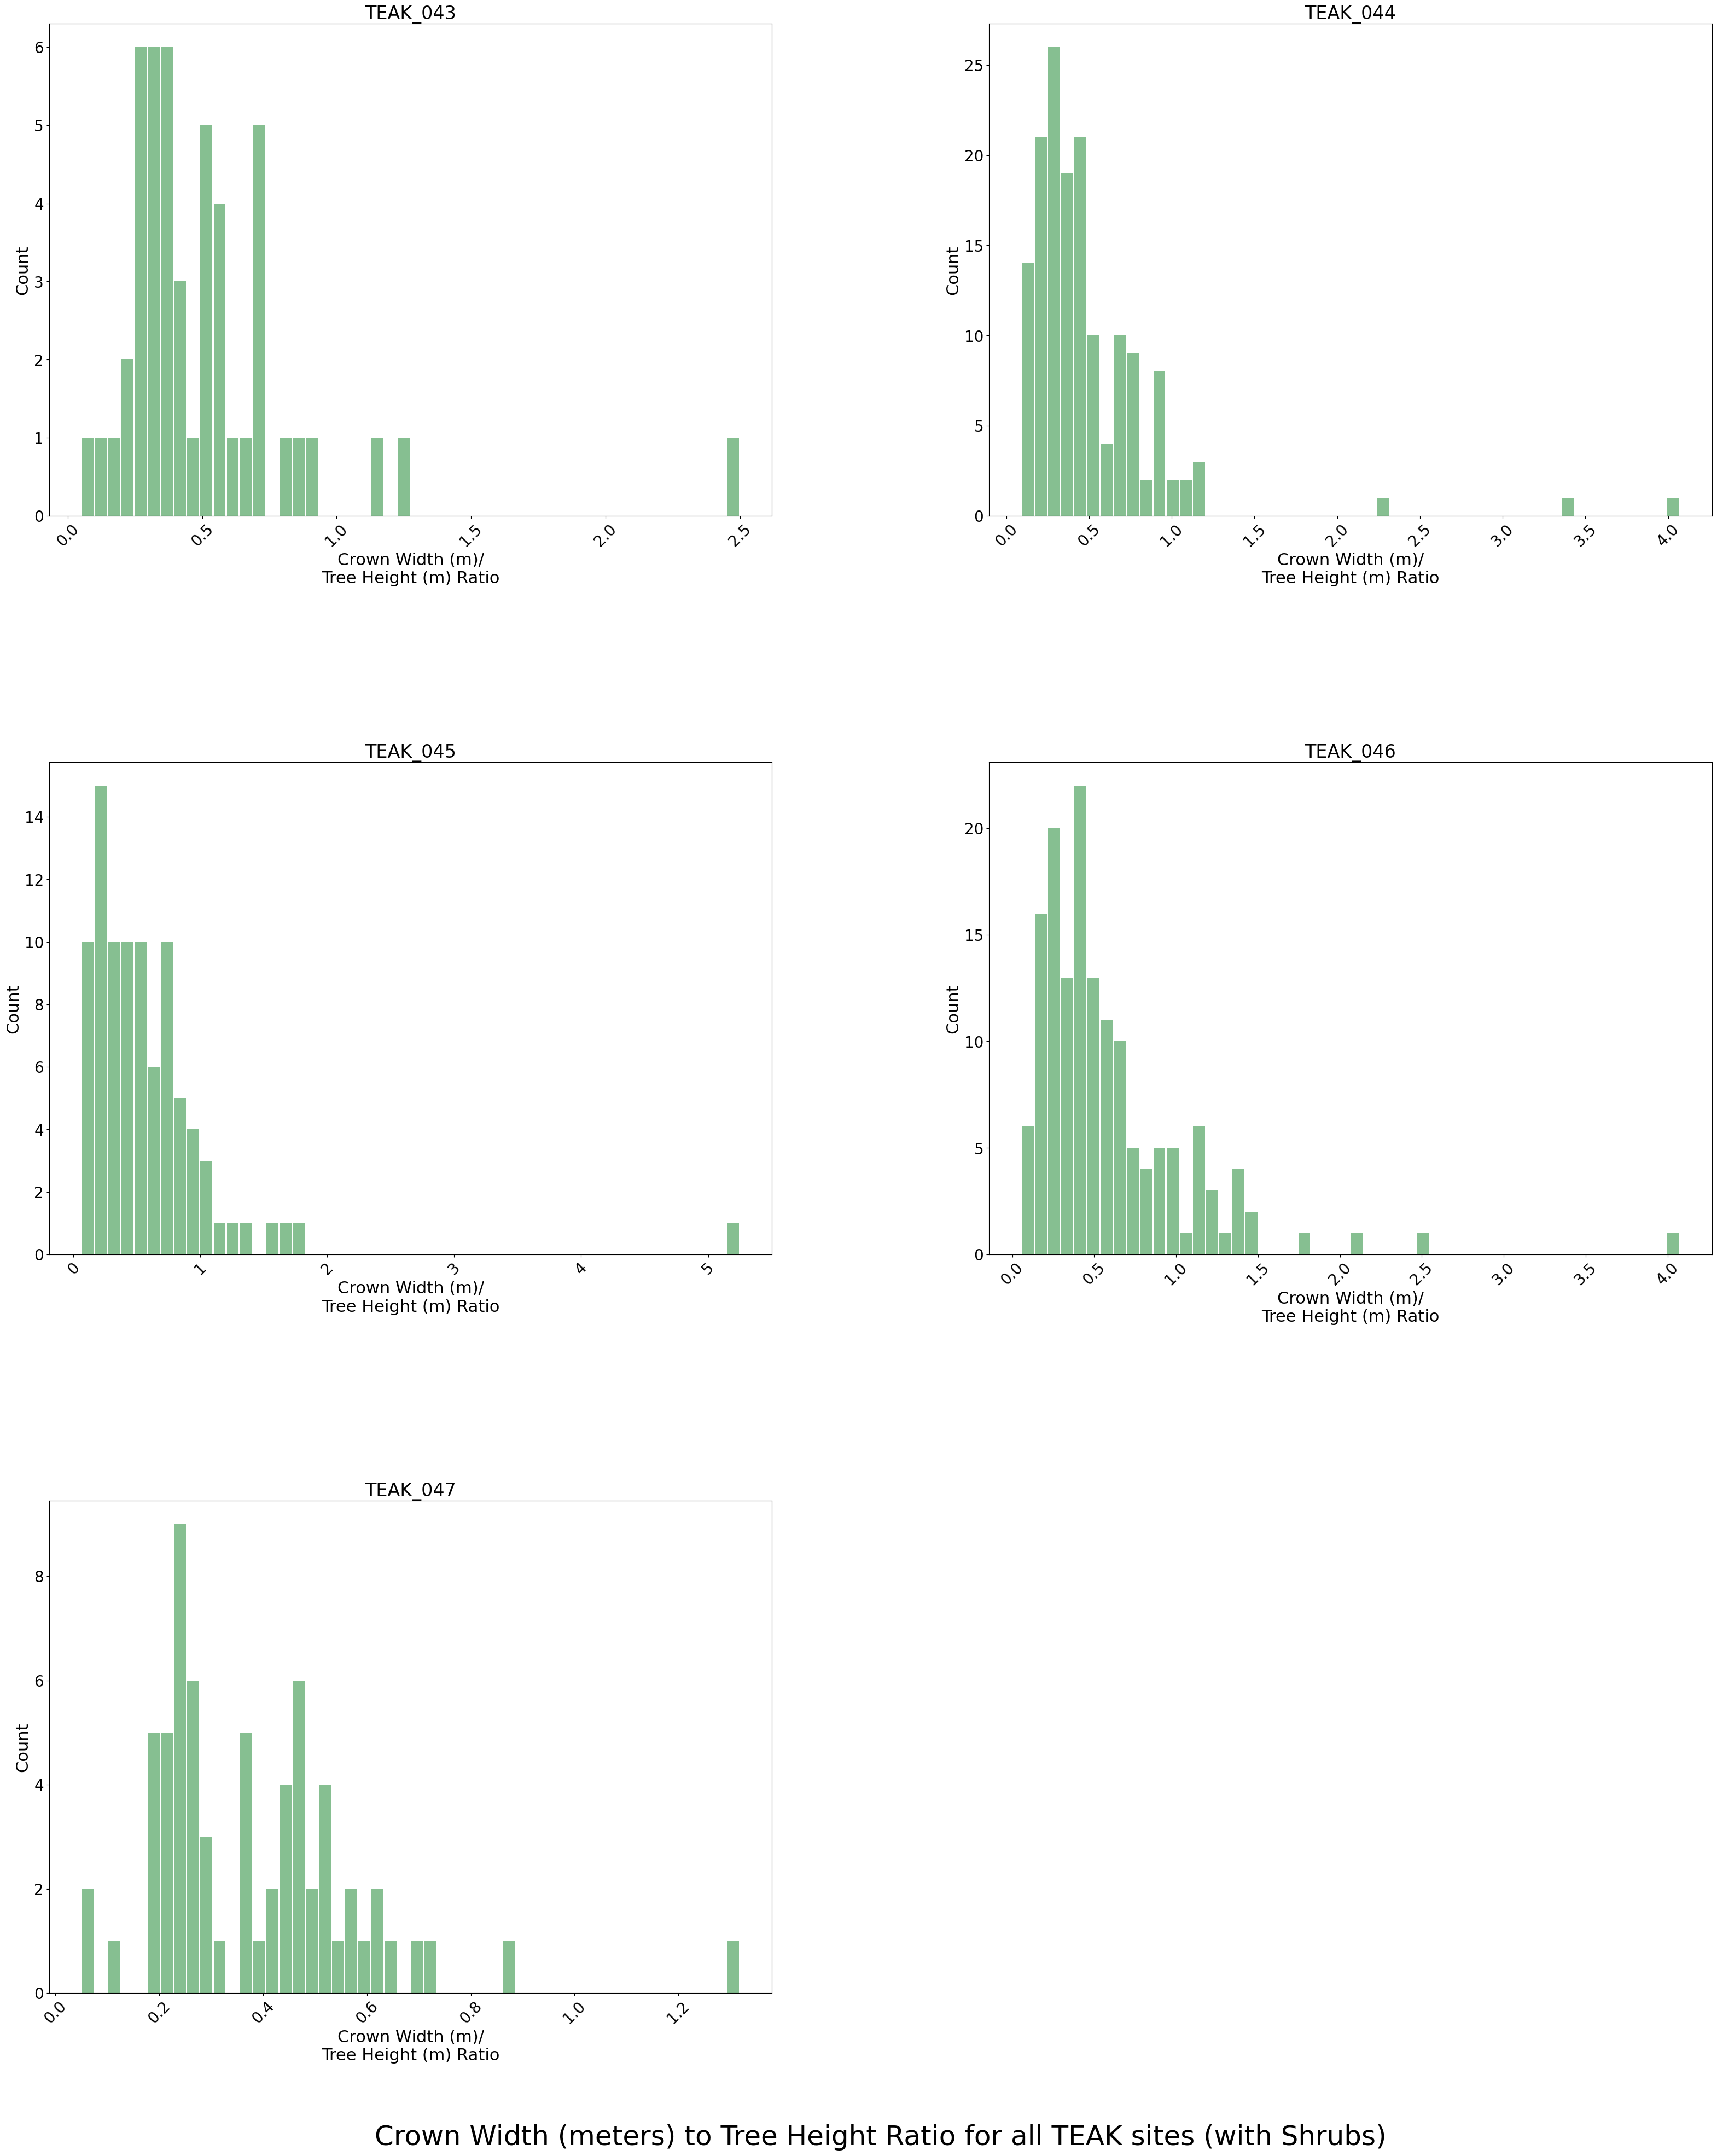

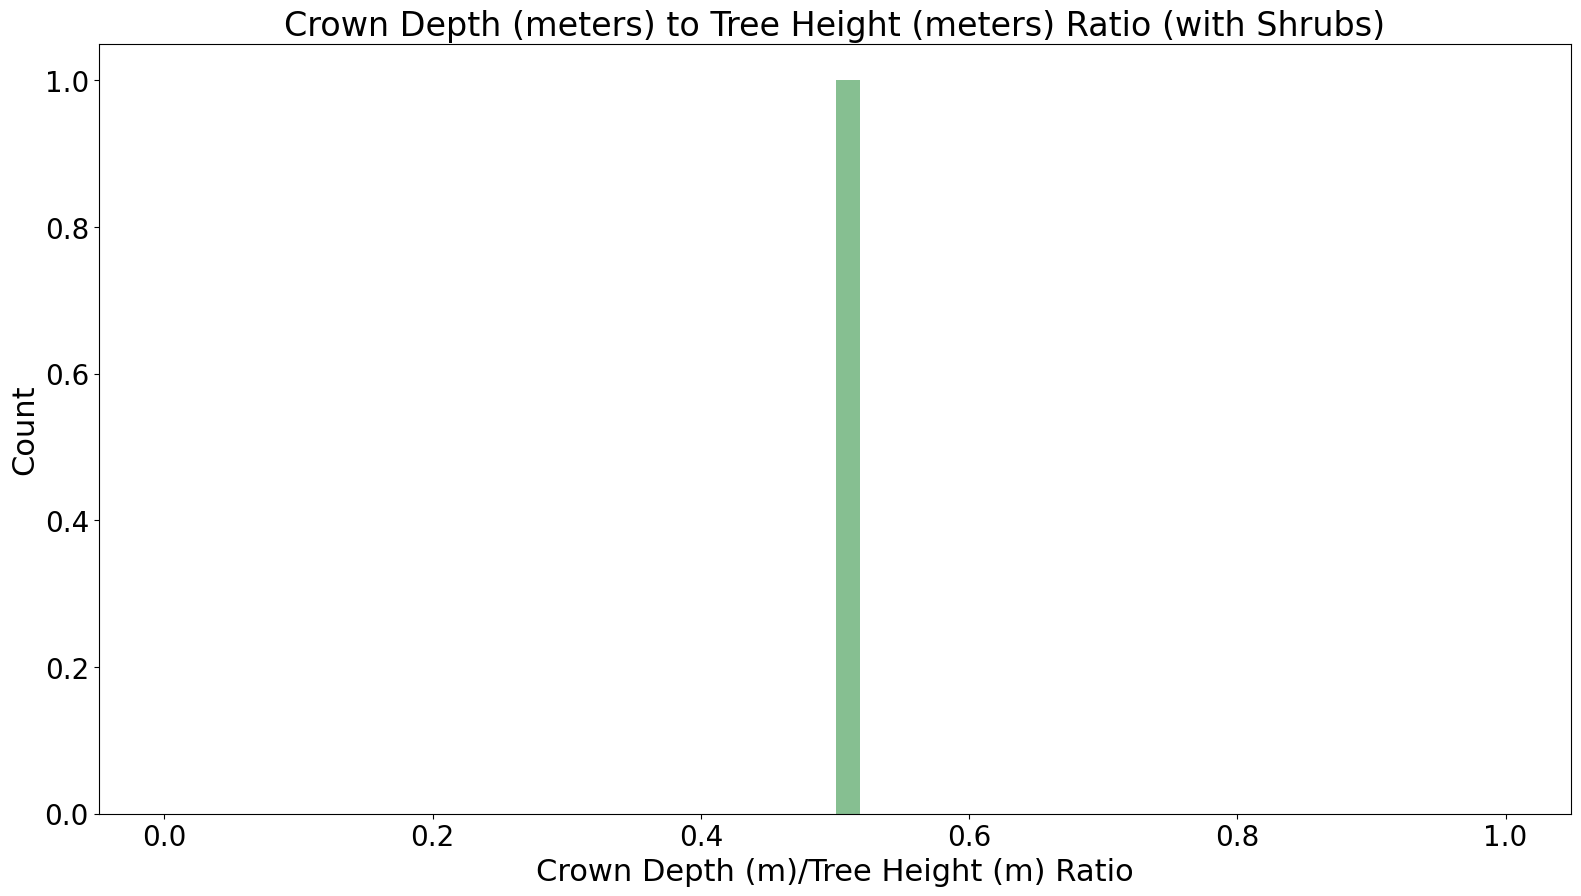

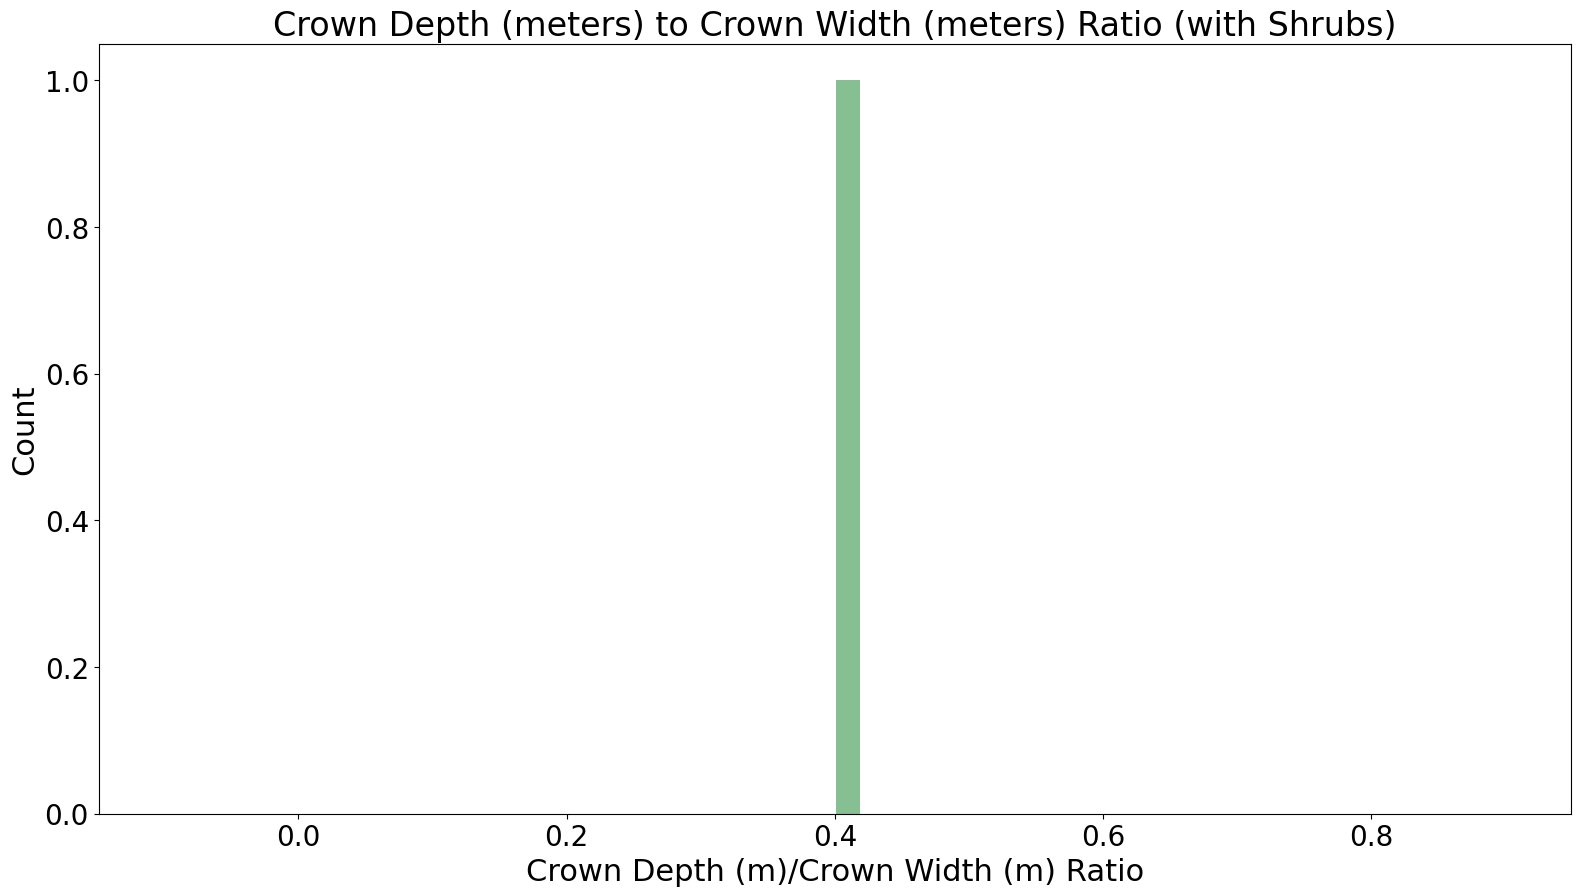

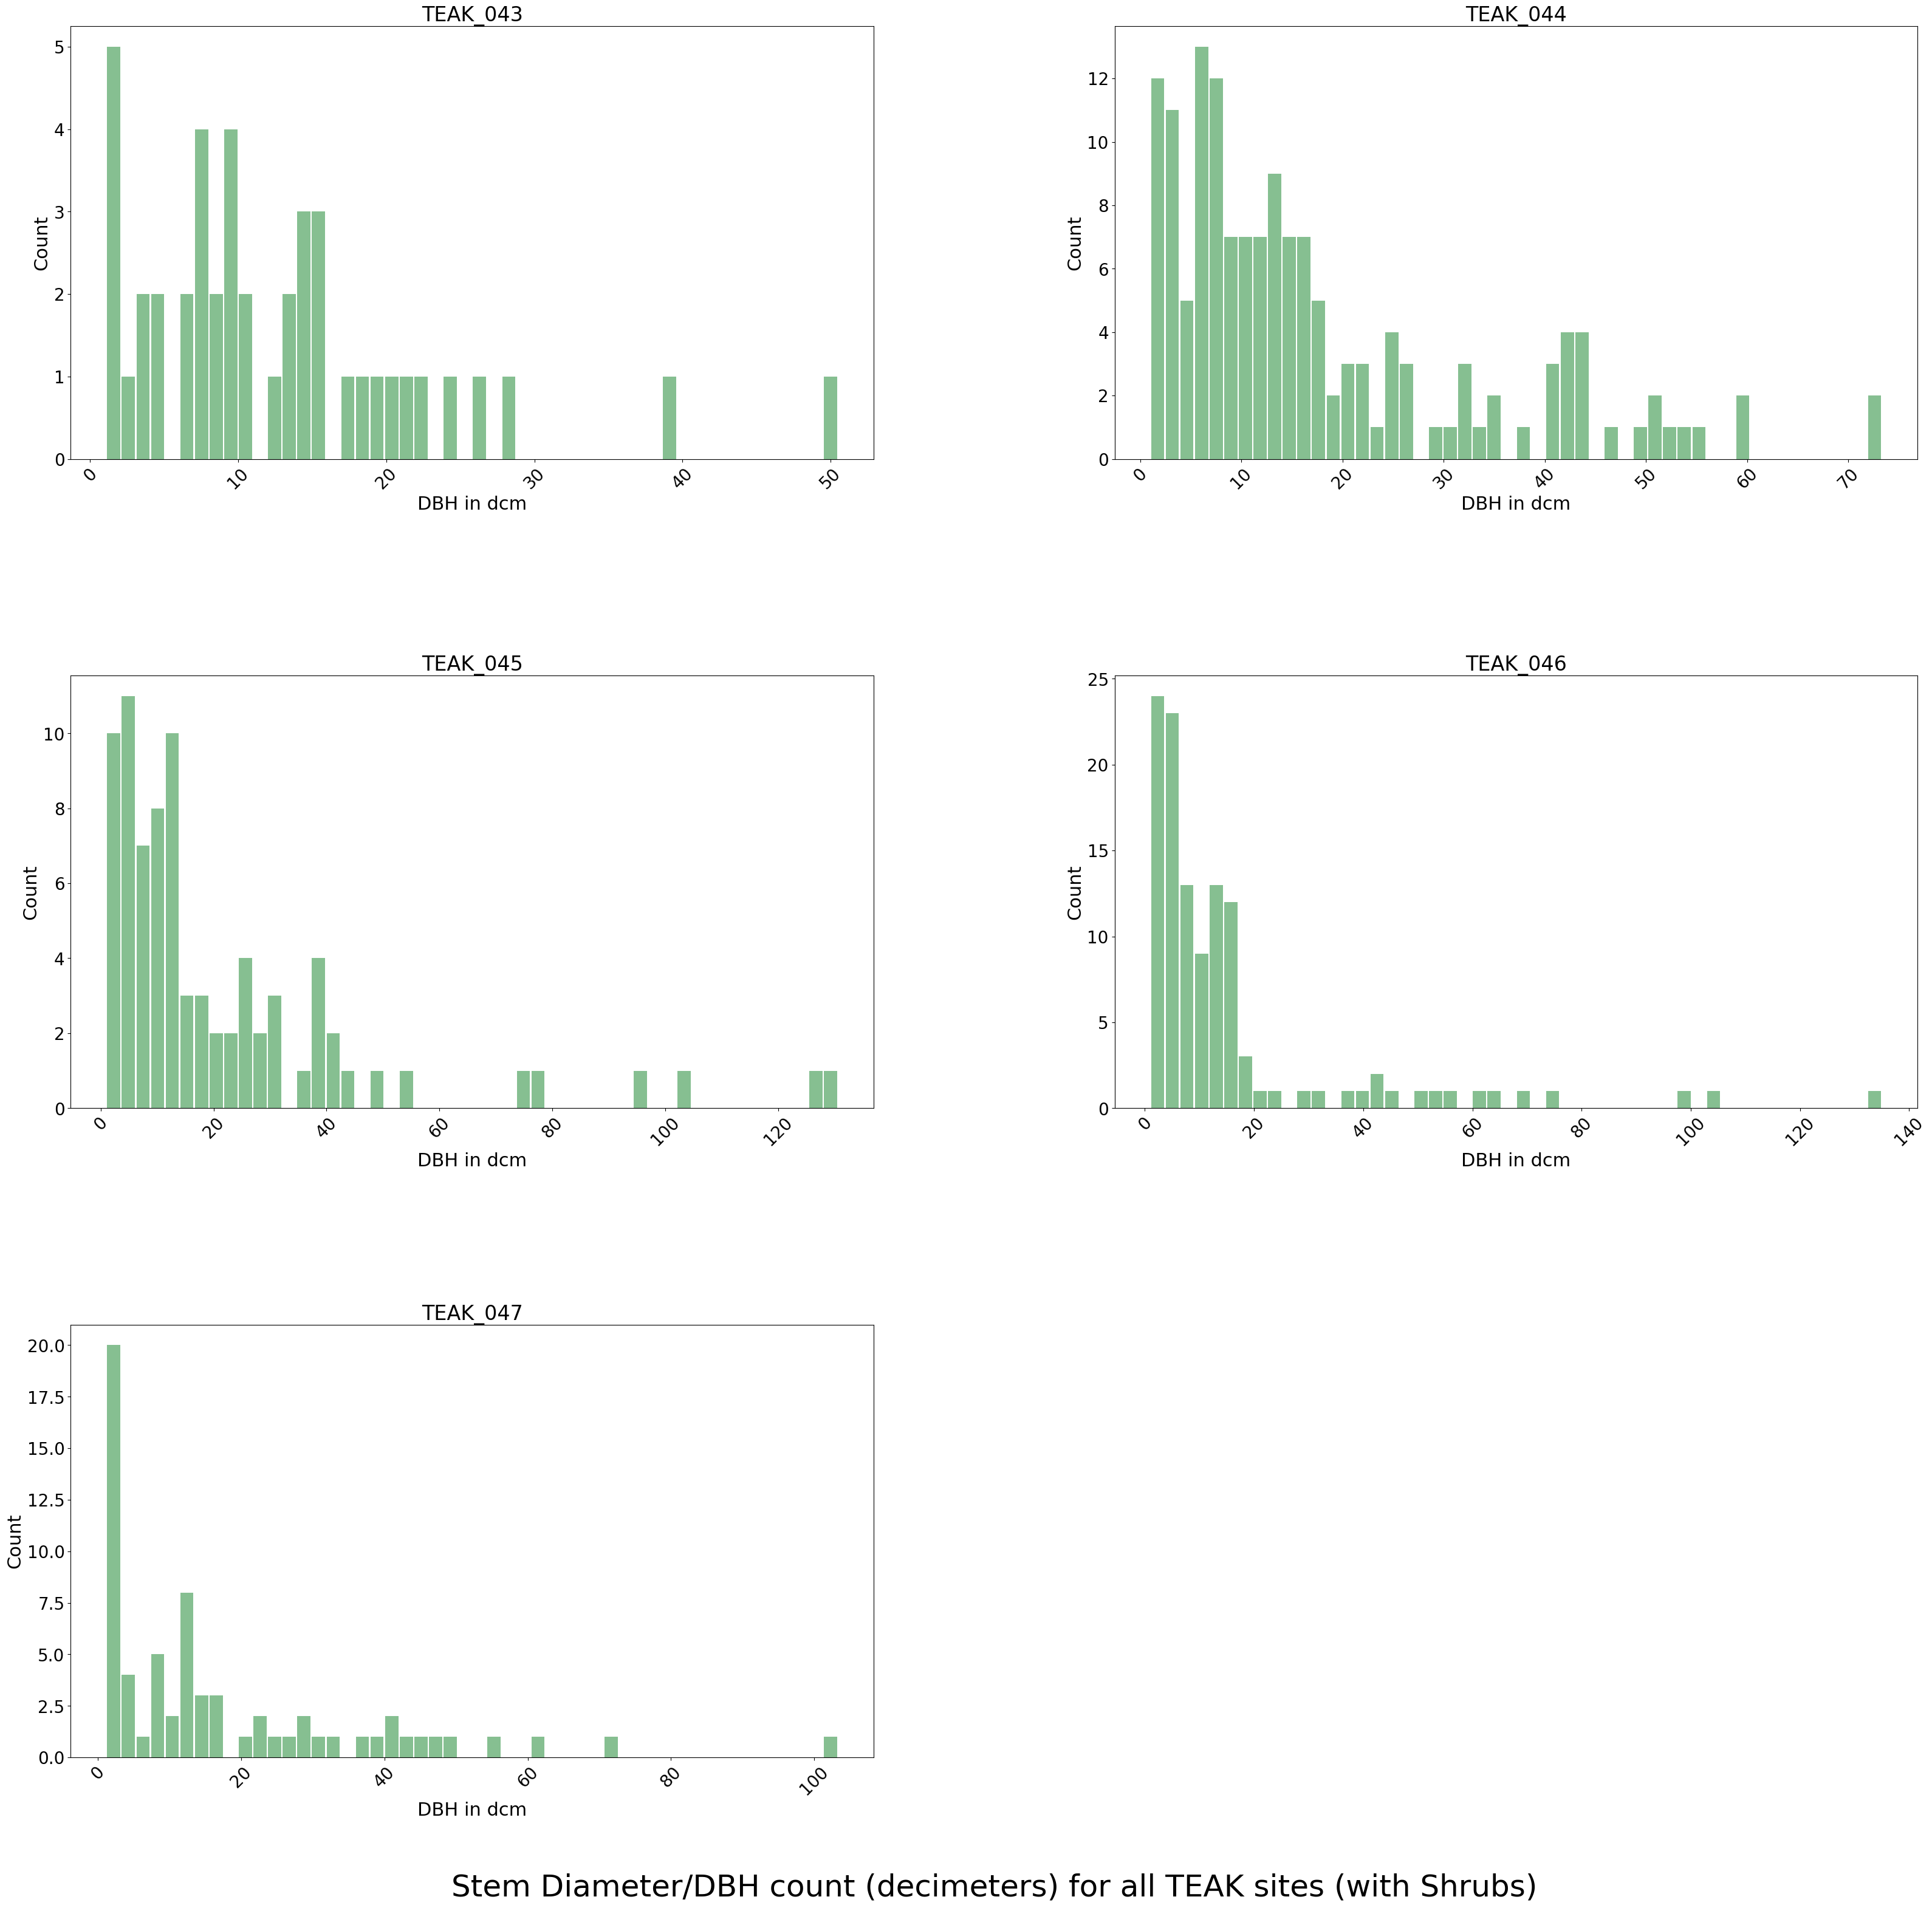

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

with_shrub_path = 'C:/Users/allen/OneDrive/Desktop/Work/Scripts/Tree Segmentation/output/with_shrub/'
without_shrub_path = 'C:/Users/allen/OneDrive/Desktop/Work/Scripts/Tree Segmentation/output/without_shrub/'

app_indv = pd.read_csv("C:/Users/allen/OneDrive/Desktop/Work/data/Tree Segmentation/TEAK/NEON_struct-plant/TEAK_appindv_allyears_2022.csv")

# with_shrub_path = '/data/allen/NEON/output/with_shrub/'
# without_shrub_path = '/data/allen/NEON/output/without_shrub/'

# app_indv = pd.read_csv("TEAK_appindv_allyears_2022.csv")

# filter out saplings and stem diameter greater than 1cm

# filtered_df = app_indv[app_indv['growthForm'].str.contains('sapling') == False]
# filtered_df = filtered_df[(filtered_df['stemDiameter'] > 0.1) | (filtered_df['stemDiameter'].isnull())]

# # set new values and ratios

# filtered_df ['crown_radius'] = (filtered_df['maxCrownDiameter'] + filtered_df["ninetyCrownDiameter"])/4
# filtered_df ['crown_width'] = (filtered_df ['crown_radius'] * 2)
# filtered_df ['crown_depth'] = filtered_df ['height'] - filtered_df ['baseCrownHeight']
# filtered_df ['crown_width/h'] = (filtered_df ['crown_radius'] * 2) / filtered_df ['height']
# filtered_df ['crown_depth/h'] = (filtered_df ['height'] - filtered_df ['baseCrownHeight'])/filtered_df ['height']
# filtered_df ['crown_depth/crown_width'] = (filtered_df ['height'] - filtered_df ['baseCrownHeight'])/(2 * filtered_df ['crown_radius'])

# # other dataframes

# most_recent_df = filtered_df[filtered_df['date'].str.contains('2015') == False]
# shrub_cr_nona_df = most_recent_df[most_recent_df['crown_radius'].notna()]
# shrub_stem_nona_df = most_recent_df[most_recent_df['stemDiameter'].notna()]
# noshrub_df = most_recent_df[most_recent_df['growthForm'].str.contains('shrub') == False]
# noshrub_noheightna_df = noshrub_df[noshrub_df['height'].notna()]
# noshrub_cr_nona_df = noshrub_df[noshrub_df['crown_radius'].notna()]
# noshrub_stem_nona_df = noshrub_df[noshrub_df['stemDiameter'].notna()]

# shrub_cr_nona_df = filtered_df[filtered_df['crown_radius'].notna()]
# shrub_stem_nona_df = filtered_df[filtered_df['stemDiameter'].notna()]
# noshrub_df = filtered_df[filtered_df['growthForm'].str.contains('shrub') == False]
# noshrub_cr_nona_df = noshrub_df[noshrub_df['crown_radius'].notna()]
# noshrub_stem_nona_df = noshrub_df[noshrub_df['stemDiameter'].notna()]


# plot axes sizes

plt.rcParams['axes.titlesize'] = 24
plt.rcParams['axes.labelsize'] = 22
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20

# begin plots with shrub and save to file

ax = filtered_df.hist(column = 'crown_radius', by = filtered_df ['plotID'], bins=50, grid=False, figsize=(38,38), color='#86bf91', zorder=2, rwidth=0.7, xrot=45)

for ax_y in ax:
    for ax_x in ax_y:
        ax_x.set_ylabel('Count')
        ax_x.set_xlabel('Crown Radius (m)')

plt.suptitle('Crown Radius Count (meters) for all TEAK sites (with Shrubs)', x=0.5, y=0.1, fontsize = 36)
fig = ax[0][0].get_figure()
fig.savefig(with_shrub_path + 'TEAK_crown_radius.png')

ax = filtered_df.hist(column = 'height', by = filtered_df ['plotID'], bins=50, grid=False, figsize=(38,38), color='#86bf91', zorder=2, rwidth=0.7, xrot=45)

for ax_y in ax:
    for ax_x in ax_y:
        ax_x.set_ylabel('Count')
        ax_x.set_xlabel('Tree Height (m)')

plt.suptitle('Tree Height Count (meters) for all TEAK sites (with Shrubs)', x=0.5, y=0.1, fontsize = 36)
fig = ax[0][0].get_figure()
fig.savefig(with_shrub_path + 'TEAK_height.png')

ax = filtered_df.hist(column = 'crown_width/h', by = filtered_df ['plotID'], bins=50, grid=False, figsize=(38,48), color='#86bf91', zorder=2, rwidth=0.9, xrot=45)

for ax_y in ax:
    for ax_x in ax_y:
        ax_x.set_ylabel('Count')
        ax_x.set_xlabel('Crown Width (m)/\nTree Height (m) Ratio')

plt.suptitle('Crown Width (meters) to Tree Height Ratio for all TEAK sites (with Shrubs)', x=0.5, y=0.1, fontsize = 36)
fig = ax[0][0].get_figure()
fig.savefig(with_shrub_path + 'TEAK_crown_width_height_ratio.png')

ax = filtered_df.hist(column = 'crown_depth/h', bins=50, grid=False, figsize=(19,10), color='#86bf91', zorder=2, rwidth=0.9)

ax[0][0].set_ylabel('Count')
ax[0][0].set_xlabel('Crown Depth (m)/Tree Height (m) Ratio')

plt.title('Crown Depth (meters) to Tree Height (meters) Ratio (with Shrubs)')
fig = ax[0][0].get_figure()
fig.savefig(with_shrub_path + 'TEAK_crown_depth_height_ratio.png')

ax = filtered_df.hist(column = 'crown_depth/crown_width', bins=50, grid=False, figsize=(19,10), color='#86bf91', zorder=2, rwidth=0.9)

ax[0][0].set_ylabel('Count')
ax[0][0].set_xlabel('Crown Depth (m)/Crown Width (m) Ratio')

plt.title('Crown Depth (meters) to Crown Width (meters) Ratio (with Shrubs)')
fig = ax[0][0].get_figure()
fig.savefig(with_shrub_path + 'TEAK_crown_depth_crown_width_ratio.png')

ax = shrub_stem_nona_df.hist(column = 'stemDiameter', by = filtered_df ['plotID'], bins=50, grid=False, figsize=(38,38), color='#86bf91', zorder=2, rwidth=0.9, xrot=45)

for ax_y in ax:
    for ax_x in ax_y:
        ax_x.set_ylabel('Count')
        ax_x.set_xlabel('DBH in dcm')

plt.suptitle('Stem Diameter/DBH count (decimeters) for all TEAK sites (with Shrubs)', x=0.5, y=0.1, fontsize = 36)
fig = ax[0][0].get_figure()
fig.savefig(with_shrub_path + 'TEAK_DBH.png')

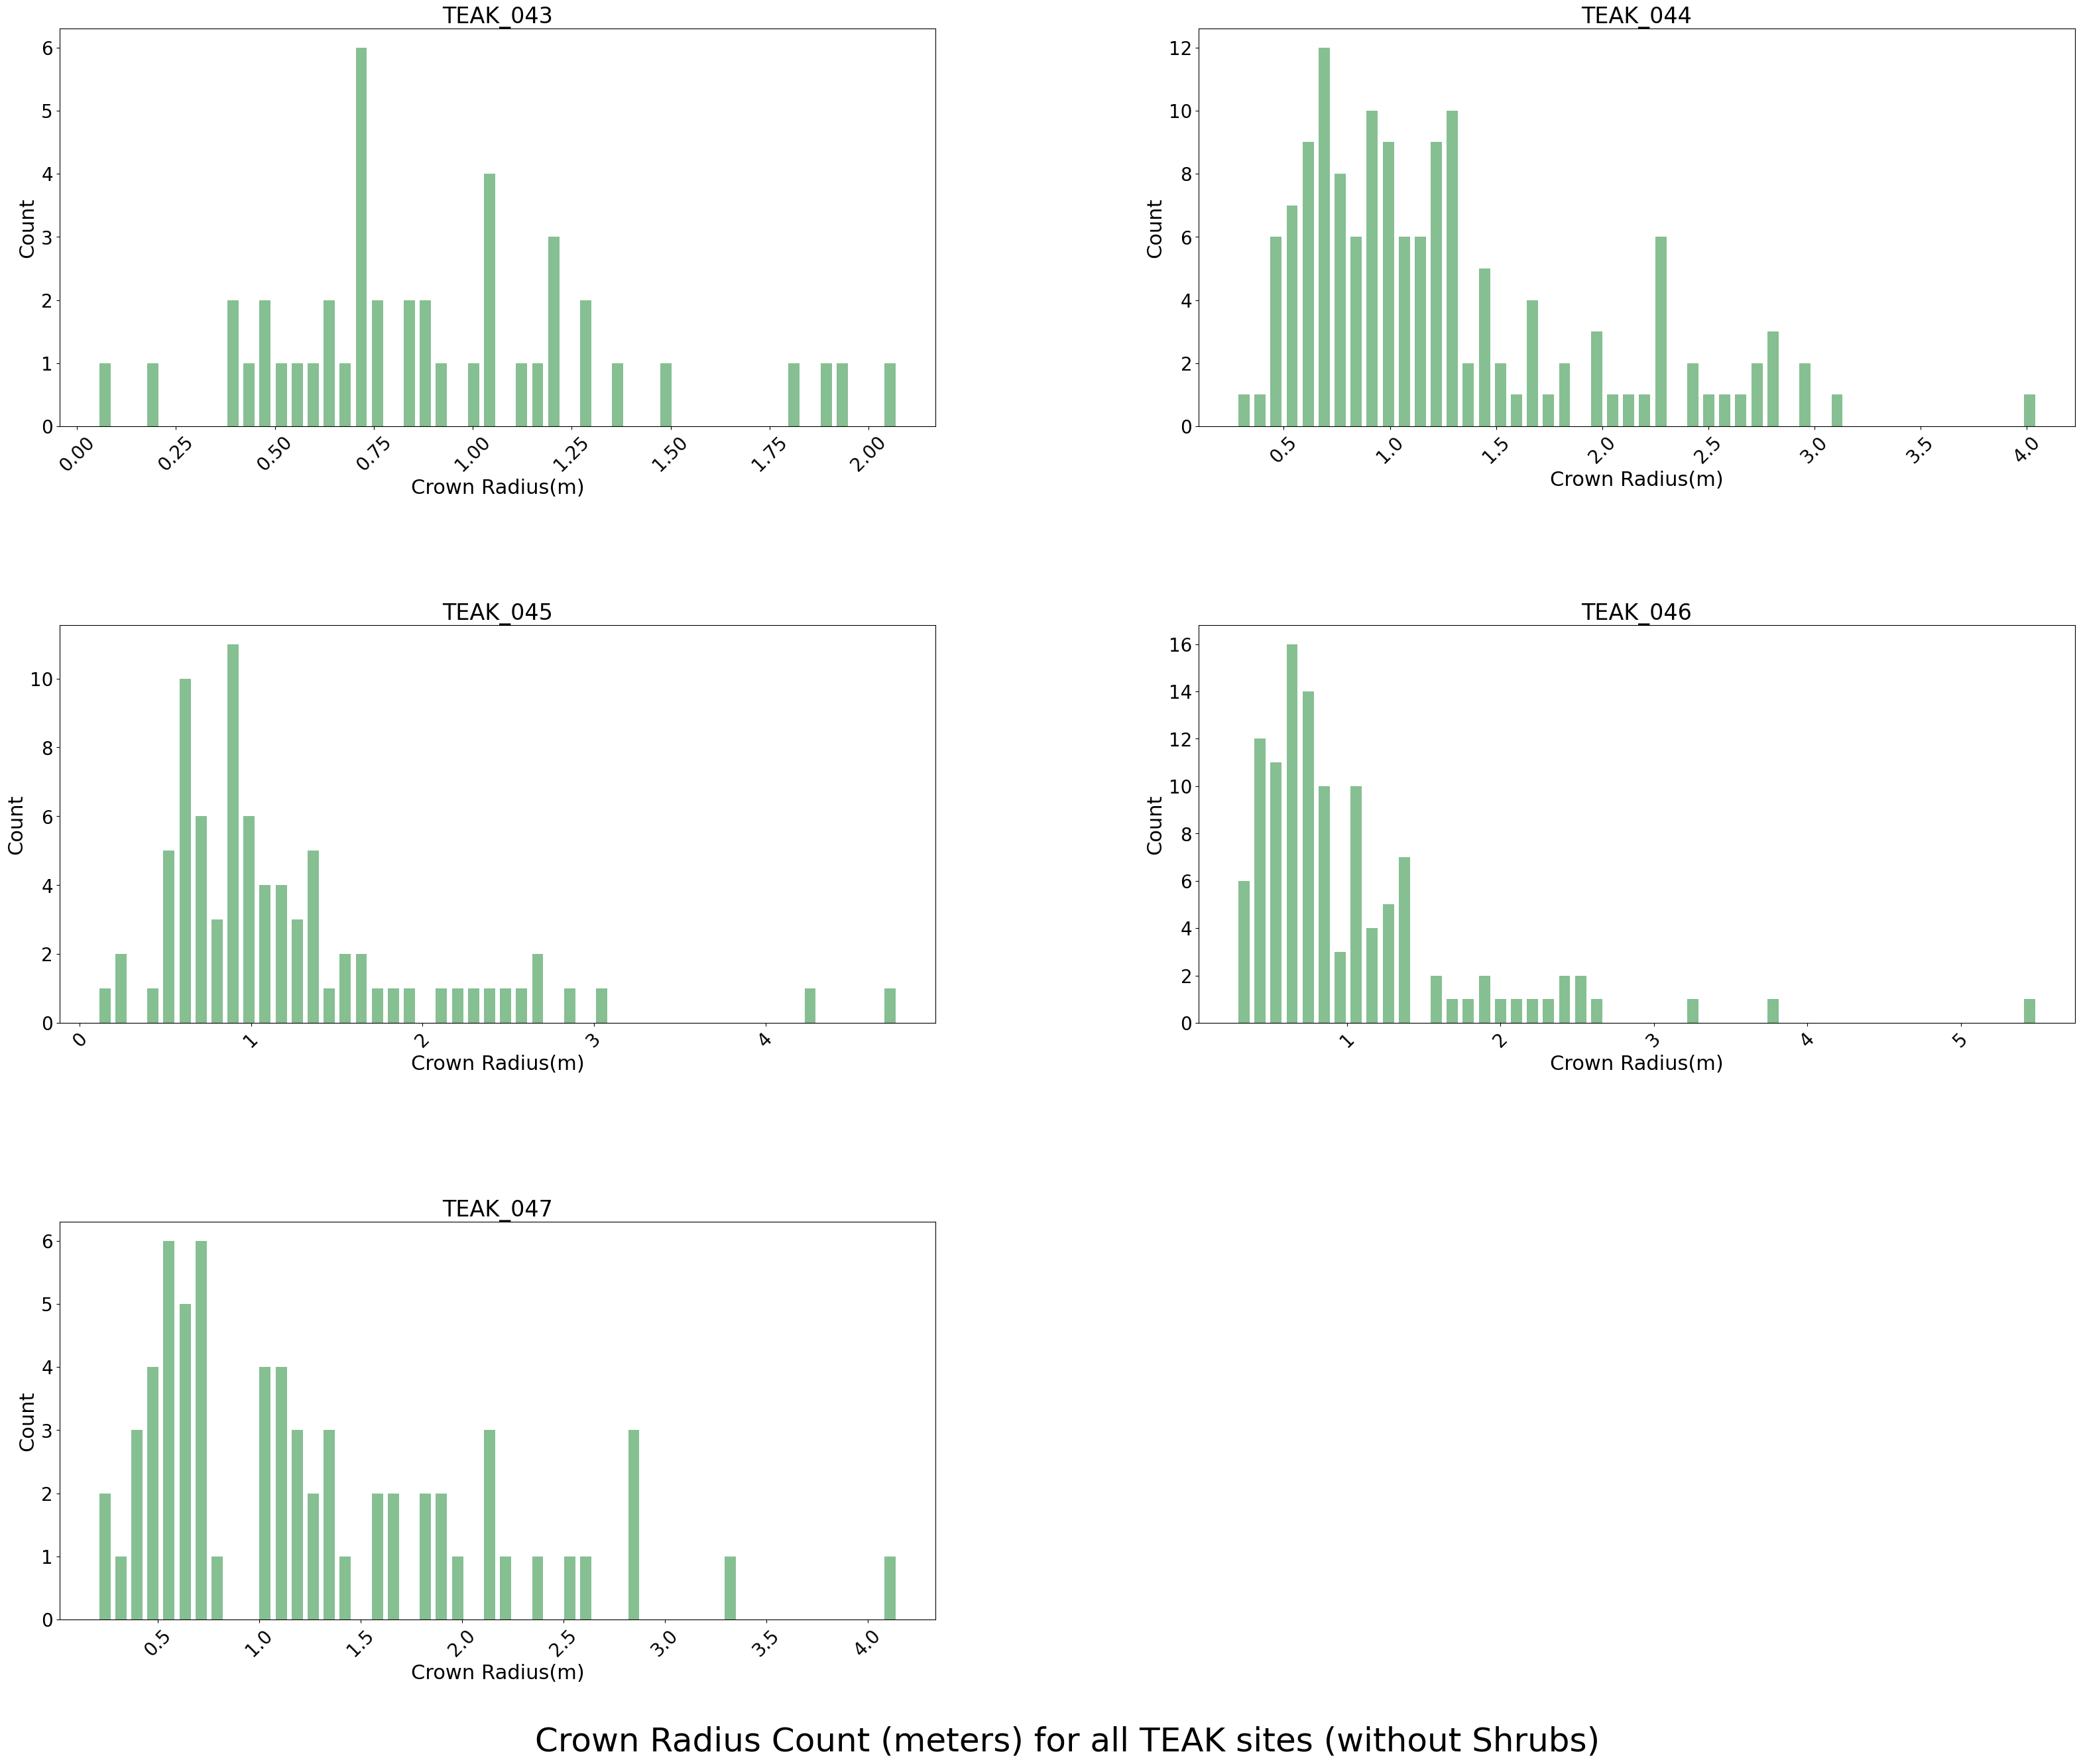

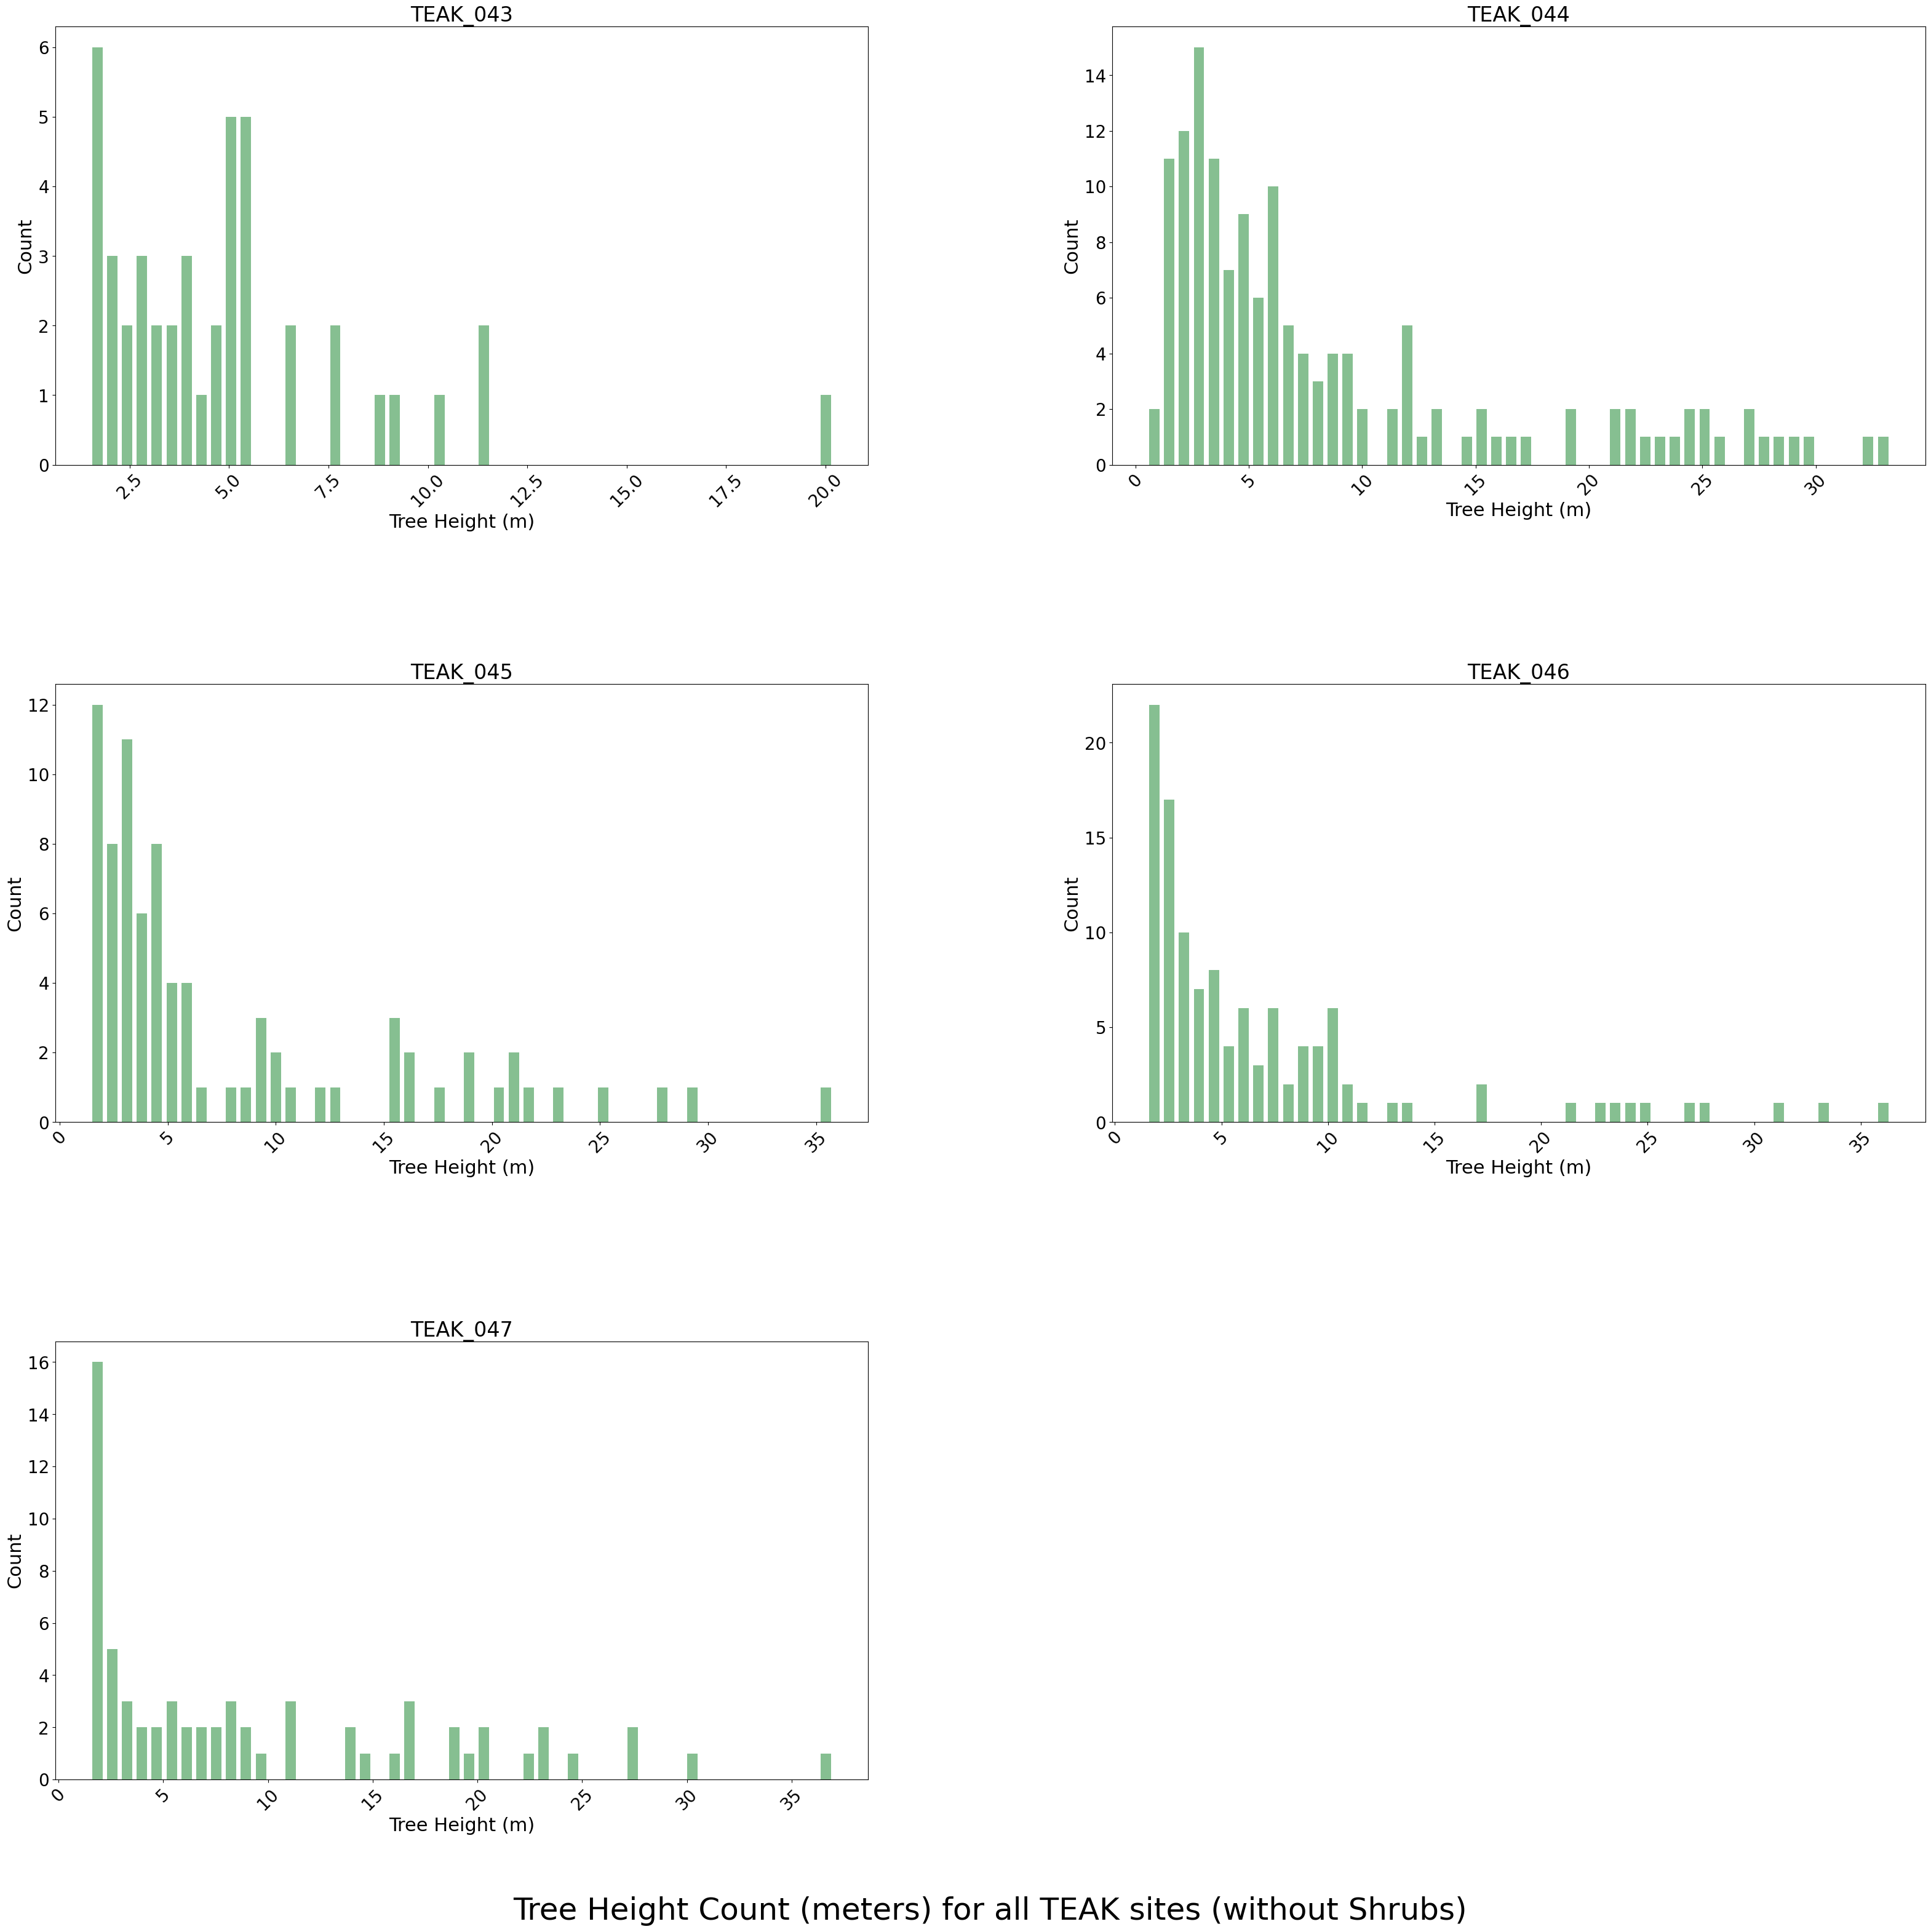

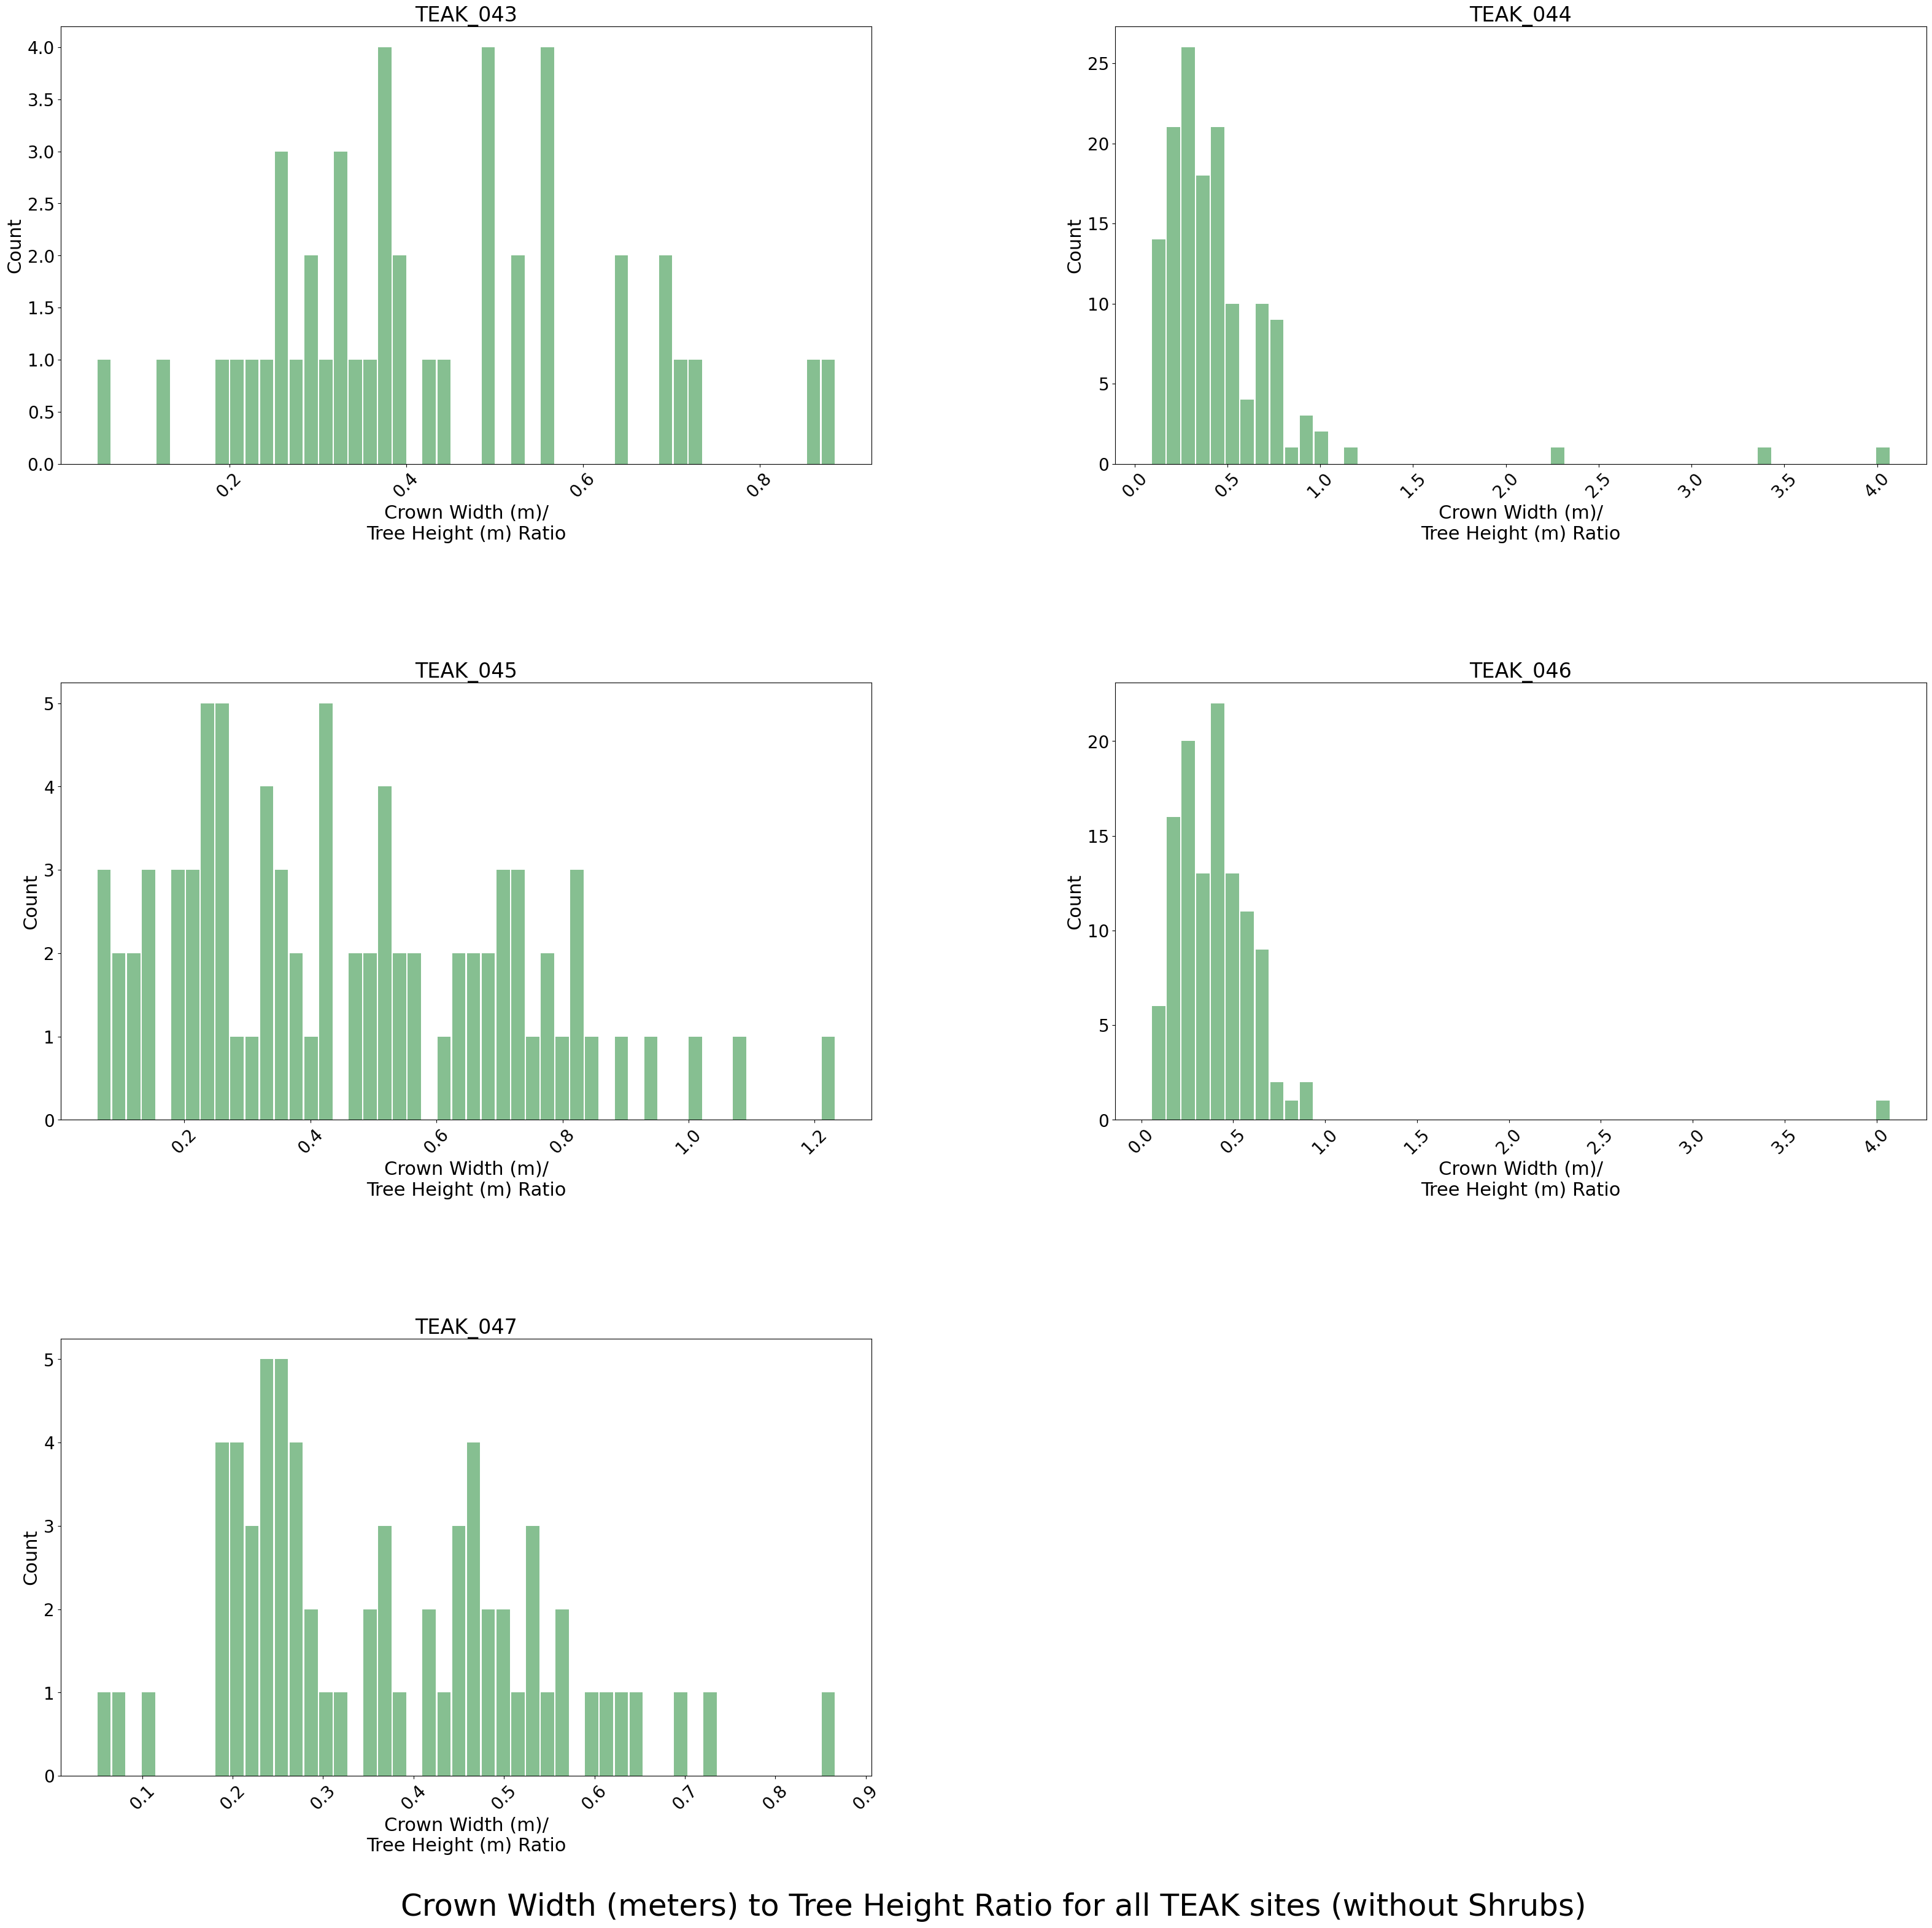

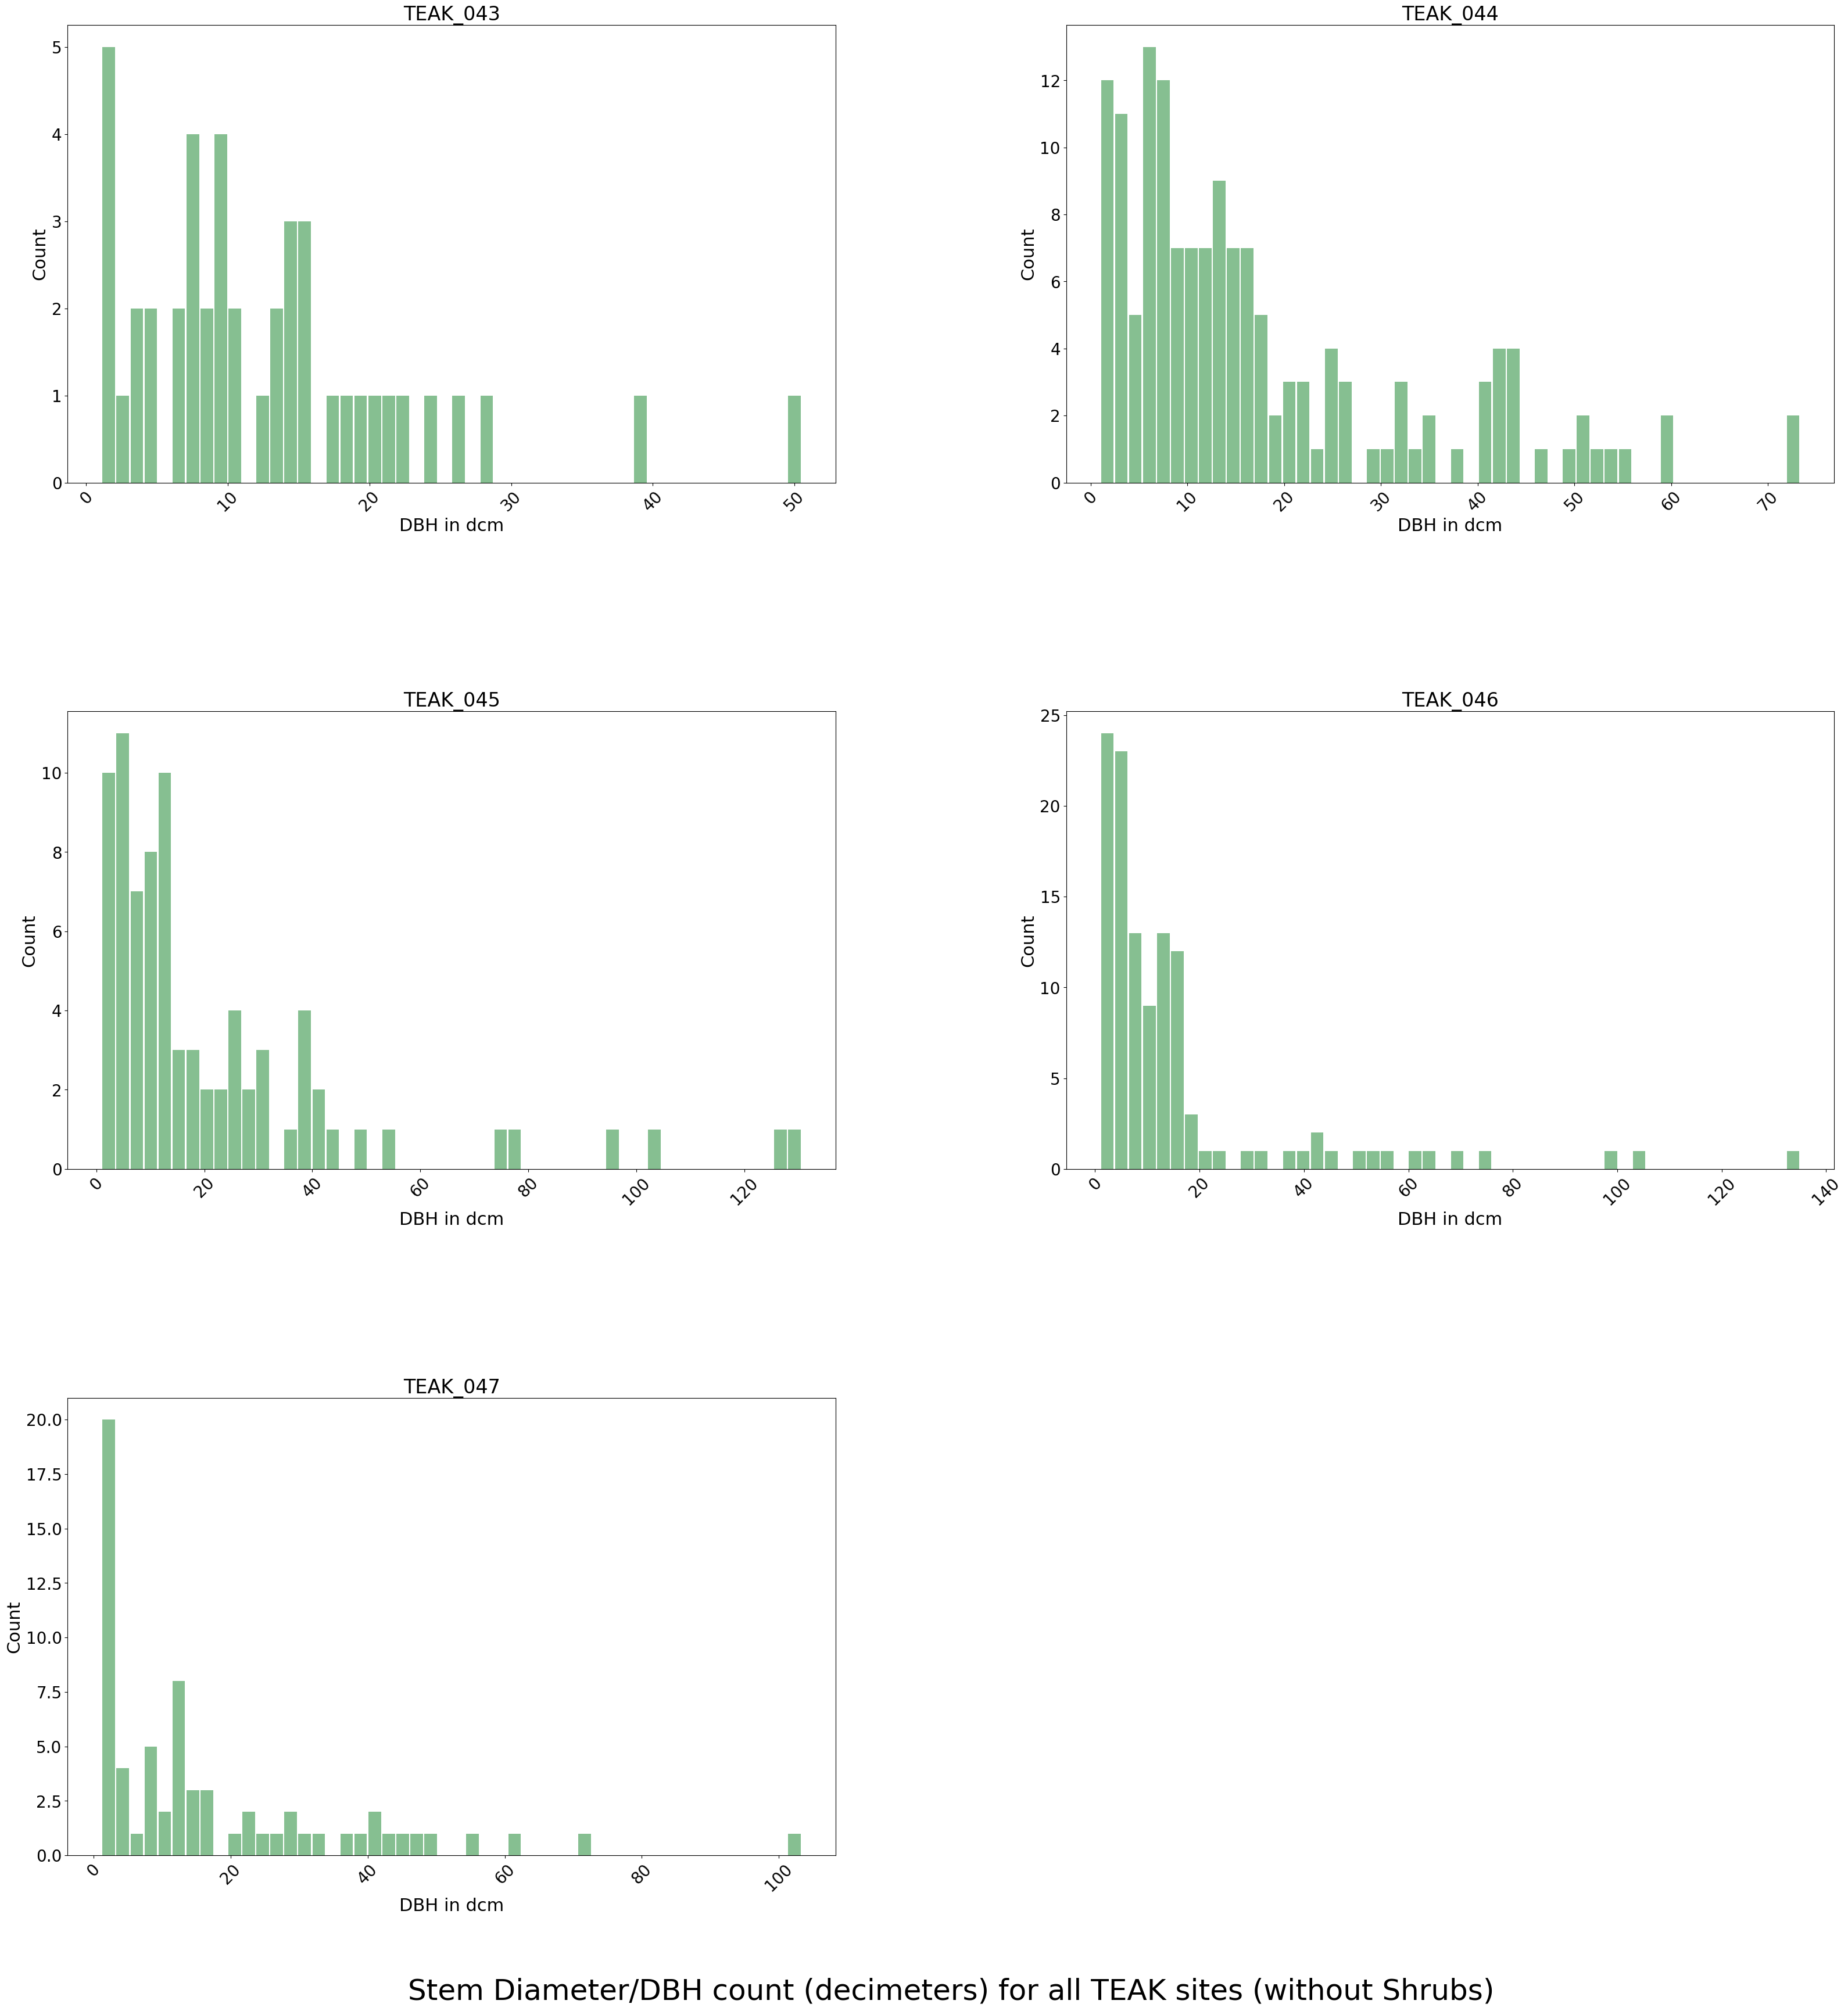

In [4]:
# begin plots without shrub and save to file

plt.rcParams['axes.titlesize'] = 24
plt.rcParams['axes.labelsize'] = 22
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20


ax = noshrub_noheightna_df.hist(column = 'crown_radius', by = noshrub_df ['plotID'], bins=50, grid=False, figsize=(38,32), color='#86bf91', zorder=2, rwidth=0.7, xrot=45)

for ax_y in ax:
    for ax_x in ax_y:
        ax_x.set_ylabel('Count')
        ax_x.set_xlabel('Crown Radius(m)')

plt.suptitle('Crown Radius Count (meters) for all TEAK sites (without Shrubs)', x=0.5, y=0.1, fontsize = 36)
fig = ax[0][0].get_figure()
fig.savefig(without_shrub_path + 'TEAK_crown_radius.png')

ax = noshrub_noheightna_df.hist(column = 'height', by = noshrub_noheightna_df ['plotID'], bins=50, grid=False, figsize=(38,38), color='#86bf91', zorder=2, rwidth=0.7, xrot=45)

for ax_y in ax:
    for ax_x in ax_y:
        ax_x.set_ylabel('Count')
        ax_x.set_xlabel('Tree Height (m)')

plt.suptitle('Tree Height Count (meters) for all TEAK sites (without Shrubs)', x=0.5, y=0.1, fontsize = 36)
fig = ax[0][0].get_figure()
fig.savefig(without_shrub_path + 'TEAK_height.png')

ax = noshrub_noheightna_df.hist(column = 'crown_width/h', by = noshrub_df ['plotID'], bins=50, grid=False, figsize=(38,38), color='#86bf91', zorder=2, rwidth=0.9, xrot=45)

for ax_y in ax:
    for ax_x in ax_y:
        ax_x.set_ylabel('Count')
        ax_x.set_xlabel('Crown Width (m)/\nTree Height (m) Ratio')

plt.suptitle('Crown Width (meters) to Tree Height Ratio for all TEAK sites (without Shrubs)', x=0.5, y=0.1, fontsize = 36)
fig = ax[0][0].get_figure()
fig.savefig(without_shrub_path + 'TEAK_crown_width_height_ratio.png')

ax = noshrub_stem_nona_df.hist(column = 'stemDiameter', by = noshrub_df ['plotID'], bins=50, grid=False, figsize=(38,42), color='#86bf91', zorder=2, rwidth=0.9, xrot=45)

for ax_y in ax:
    for ax_x in ax_y:
        ax_x.set_ylabel('Count')
        ax_x.set_xlabel('DBH in dcm')

plt.suptitle('Stem Diameter/DBH count (decimeters) for all TEAK sites (without Shrubs)', x=0.5, y=0.1, fontsize = 36)
fig = ax[0][0].get_figure()
fig.savefig(without_shrub_path + 'TEAK_DBH.png')

In [5]:
# test_df = app_indv['height'].dropna()

# with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
#     print(test_df)

print(len(app_indv.index))

test_df = app_indv[app_indv['growthForm'].str.contains('sapling|shrub') == False]

print(len(test_df.index))

test_df = test_df[test_df['stemDiameter'] > 1]

print(len(test_df.index))

5062
2688
2676


C:\Users\allen\AppData\Local\Temp\ipykernel_16768\623994923.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  noshrub_df.sort_values(by='plotID', inplace=True)


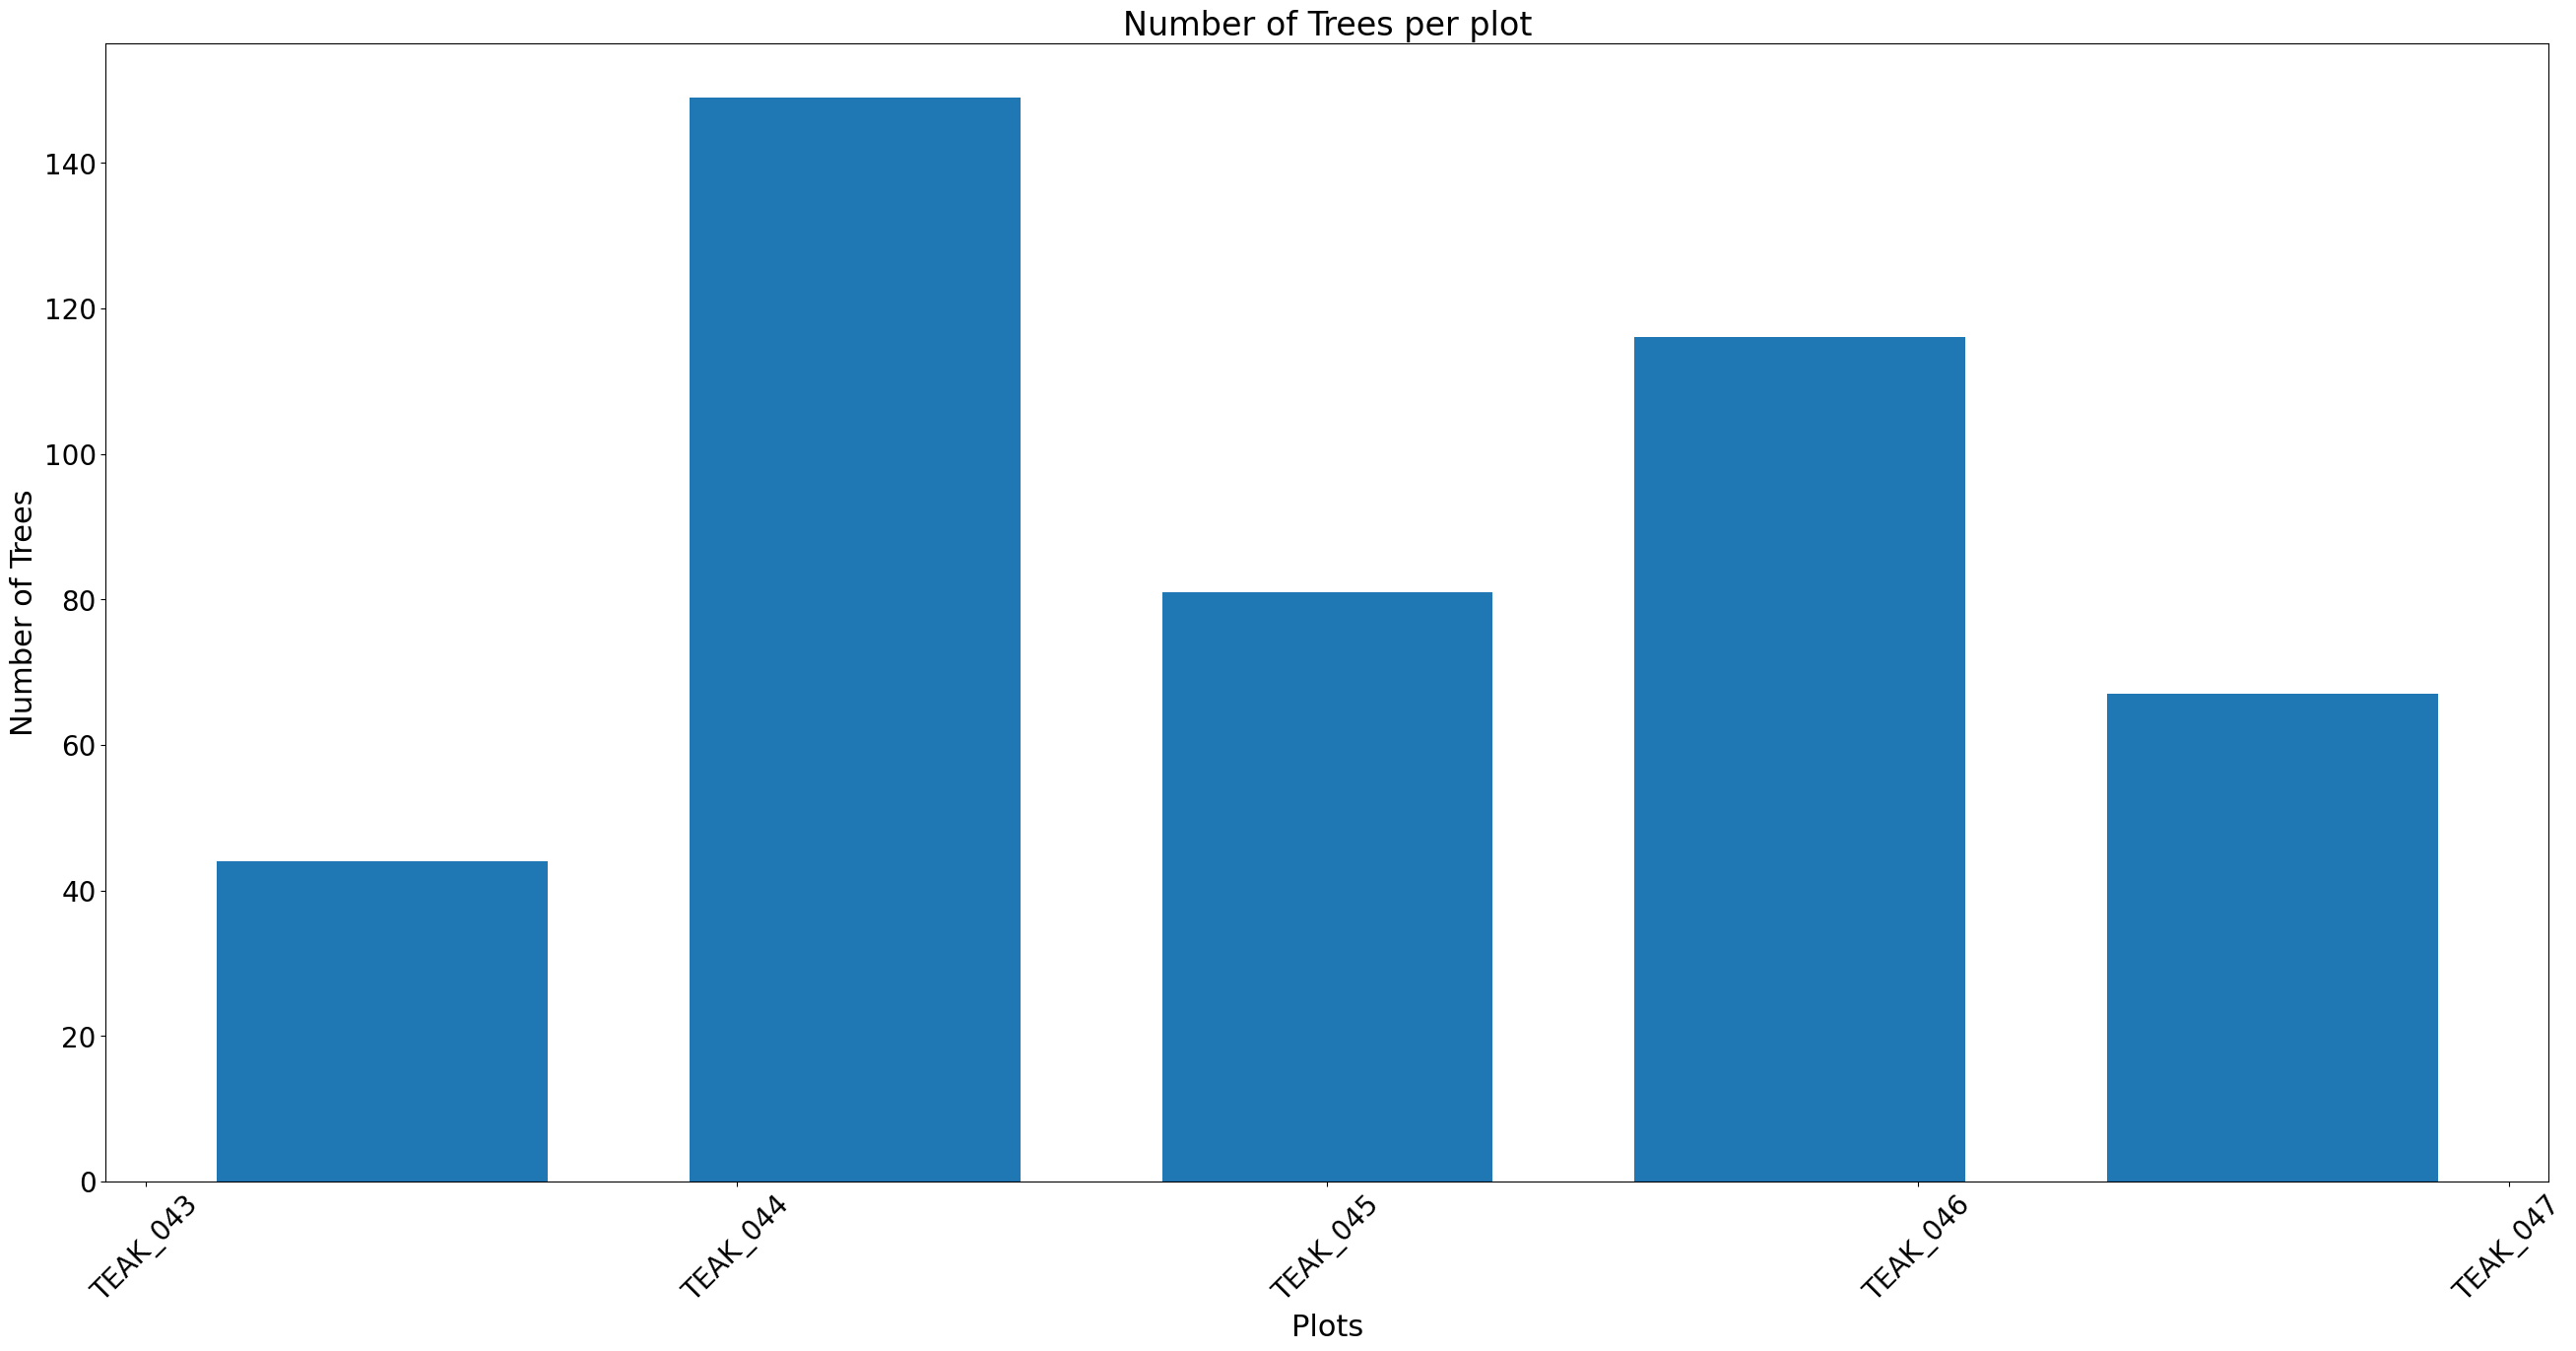

In [6]:
noshrub_df.sort_values(by='plotID', inplace=True)


# print (noshrub_df)
# print (noshrub_df['plotID'].unique())
# print (noshrub_df['plotID'].nunique())
# print (noshrub_df['plotID'].value_counts())

# ax = filtered_df.hist(column = 'crown_depth/crown_width', bins=50, grid=False, figsize=(19,10), color='#86bf91', zorder=2, rwidth=0.9)

# ax[0][0].set_ylabel('Count')

ax = noshrub_df['plotID'].hist(bins = (noshrub_df['plotID'].nunique()), grid=False, align = 'mid', rwidth=0.7, figsize=(32,15), xrot = 45)

ax.set_title('Number of Trees per plot')
ax.set_ylabel('Number of Trees')
ax.set_xlabel('Plots')

plt.rcParams['axes.titlesize'] = 24
plt.rcParams['axes.labelsize'] = 30
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20

C:\Users\allen\AppData\Local\Temp\ipykernel_16768\2466541597.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  noshrub_df.sort_values(by='plotID', inplace=True)


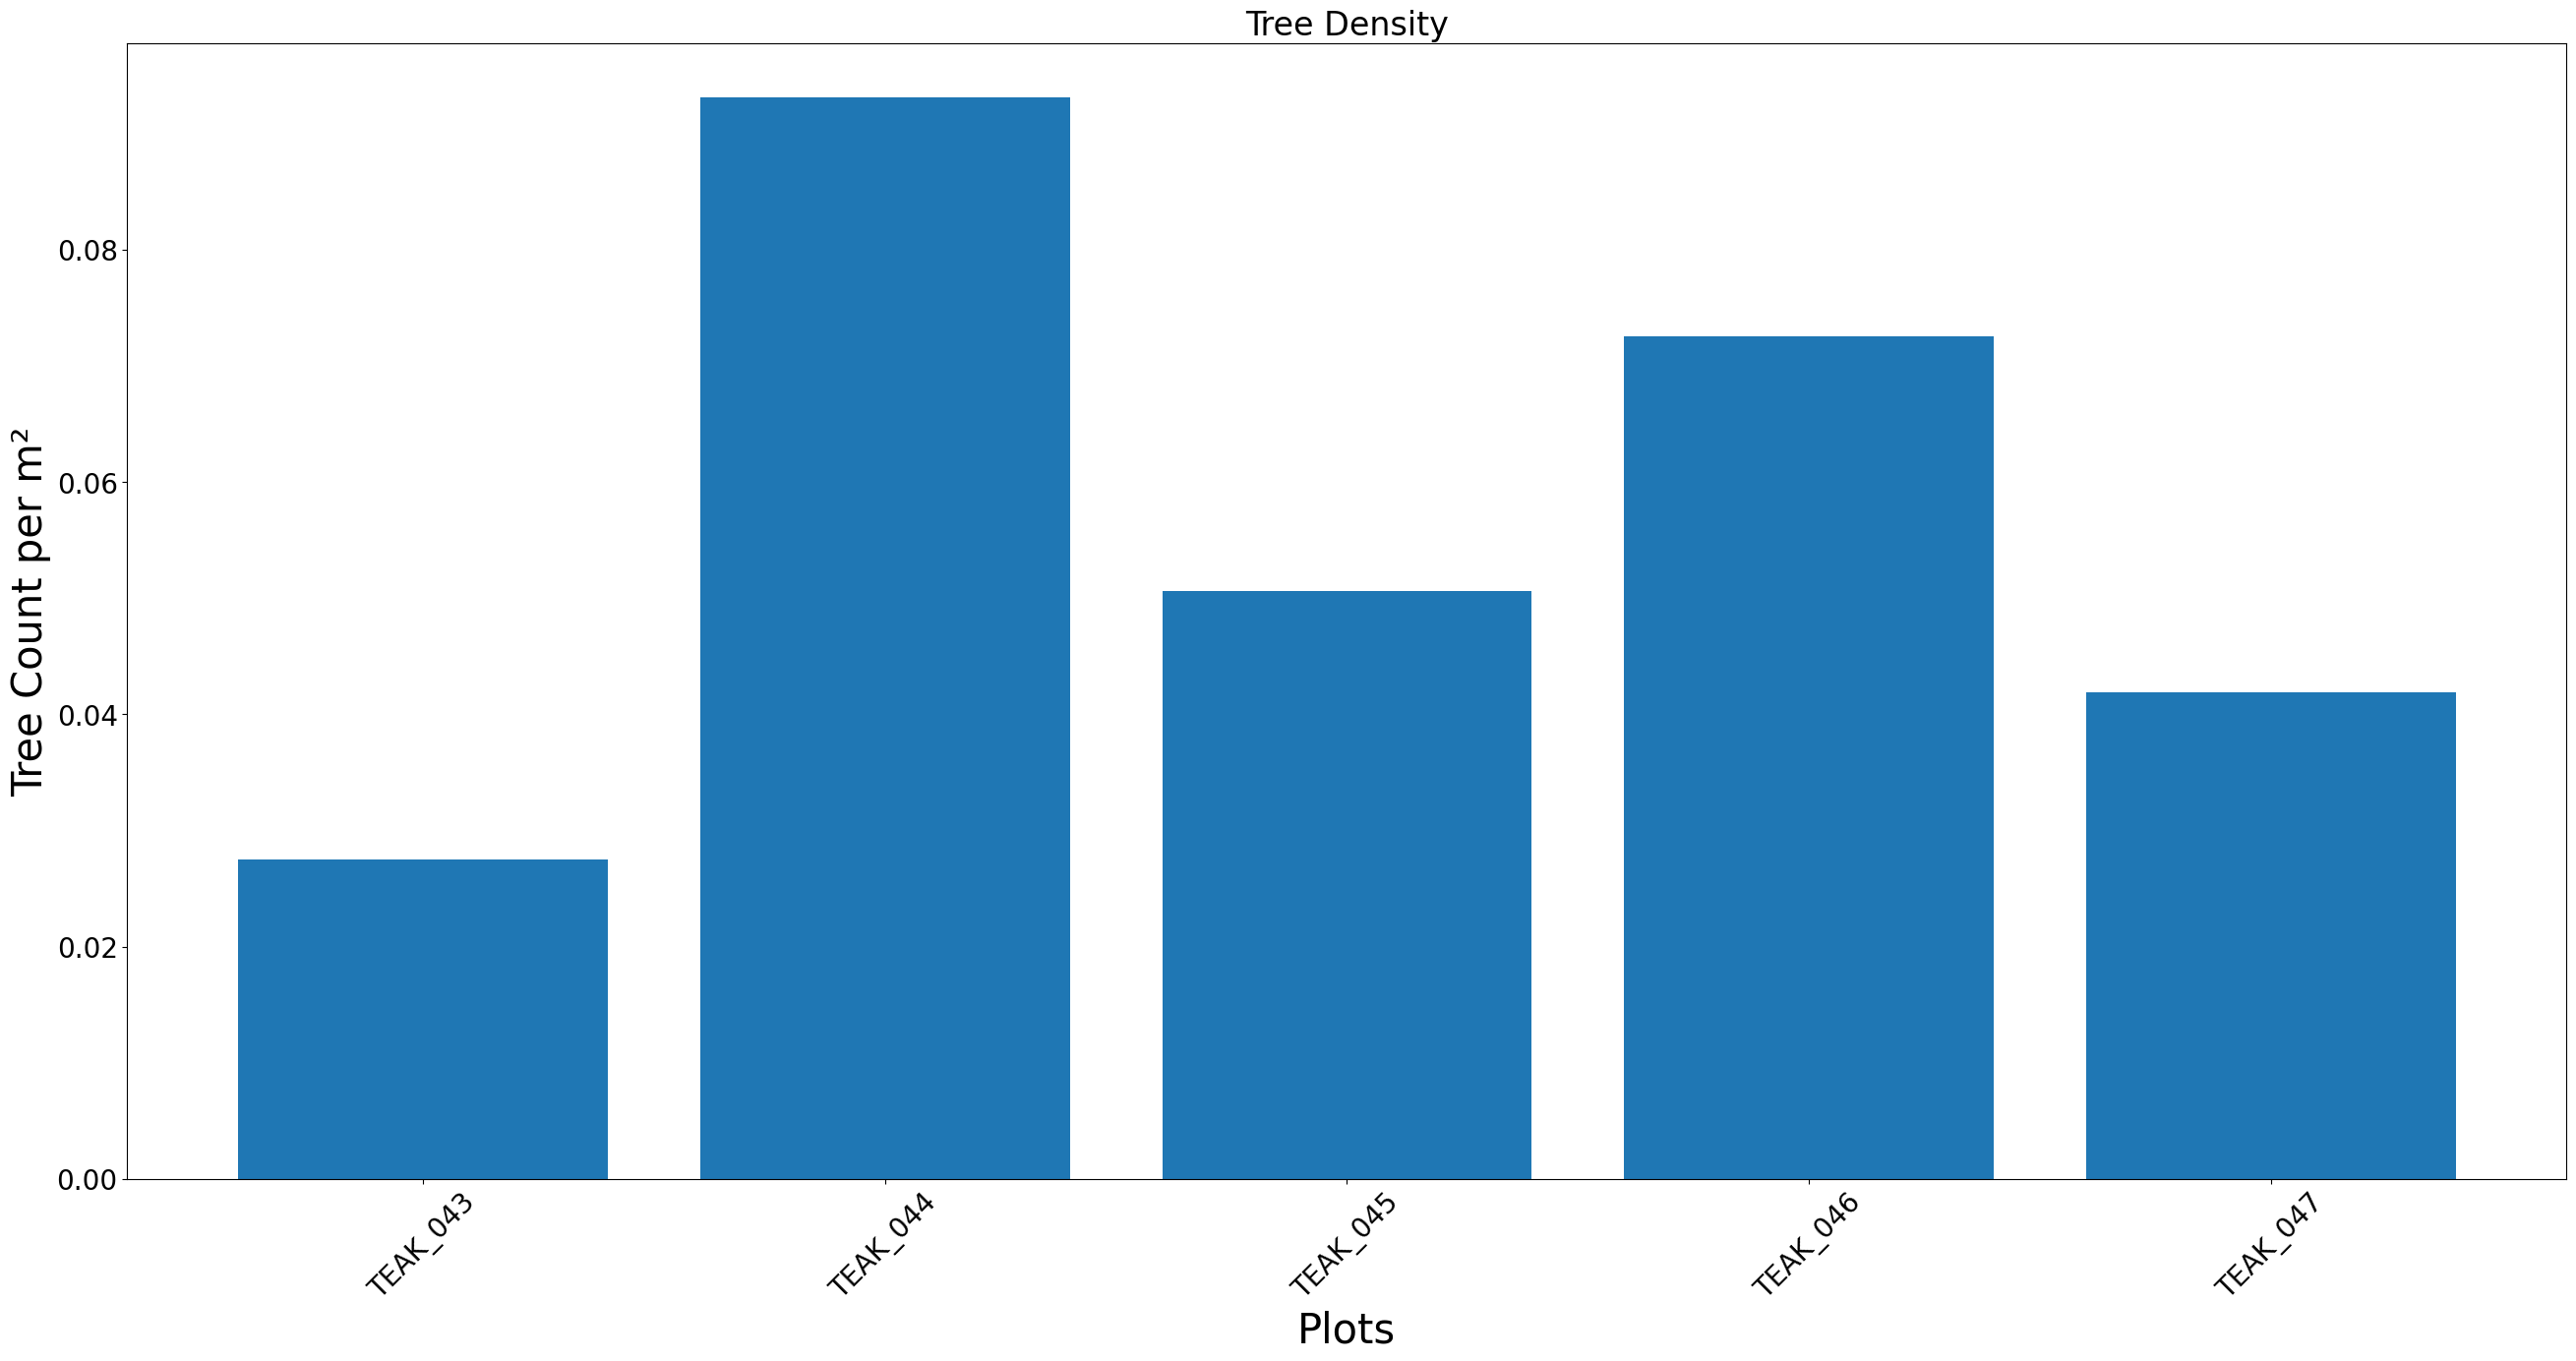

In [7]:

# path = '/data/allen/NEON/output/'

noshrub_df.sort_values(by='plotID', inplace=True)

unique_plots = noshrub_df['plotID'].unique()
# print (unique_plots)


plot_count_list = []

for plot in unique_plots:
    tree_density = (noshrub_df['plotID'].value_counts()[plot]/1600)
    count = [plot, tree_density]
    plot_count_list.append(count)

# print (plot_count_list)

plot_count_df = pd.DataFrame(plot_count_list, columns = ['plotID', 'count'])

# # with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
# #     print(plot_count_df)

# # ax = plot_count_df['count'].hist(column = 'plotID', bins = (len(plot_count_df.index) - 1), grid=False, align = 'mid', rwidth=0.7, figsize=(32,15), xrot = 45)

# plot_count_df.groupby(['plotID'])['count'].hist(bins = (len(plot_count_df.index) - 1), grid=False, align = 'mid', rwidth=0.7, figsize=(32,15), xrot = 45)

# Plotting a bar graph

plt.figure(figsize = (32,15))
bars = plt.bar(plot_count_df['plotID'], plot_count_df['count'])

# Adding labels and title
plt.xlabel('Plots')
plt.ylabel('Tree Count per m\u00B2')
plt.xticks(rotation=45)
plt.title('Tree Density')

# Calculating the position of the x-ticks
x_pos = [((bar.get_x() + bar.get_width() / 2)) for bar in bars]

# Setting x-ticks to the center of the bars
plt.xticks(x_pos, plot_count_df['plotID'])

plt.rcParams['axes.titlesize'] = 24
plt.rcParams['axes.labelsize'] = 30
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20

# Save the figure to a file
plt.savefig(root_path + 'TEAK_tree_density.png')

# Displaying the plot
plt.show()

C:\Users\allen\AppData\Local\Temp\ipykernel_16768\1738113241.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_map_tag.sort_values(by='plotID', inplace=True)


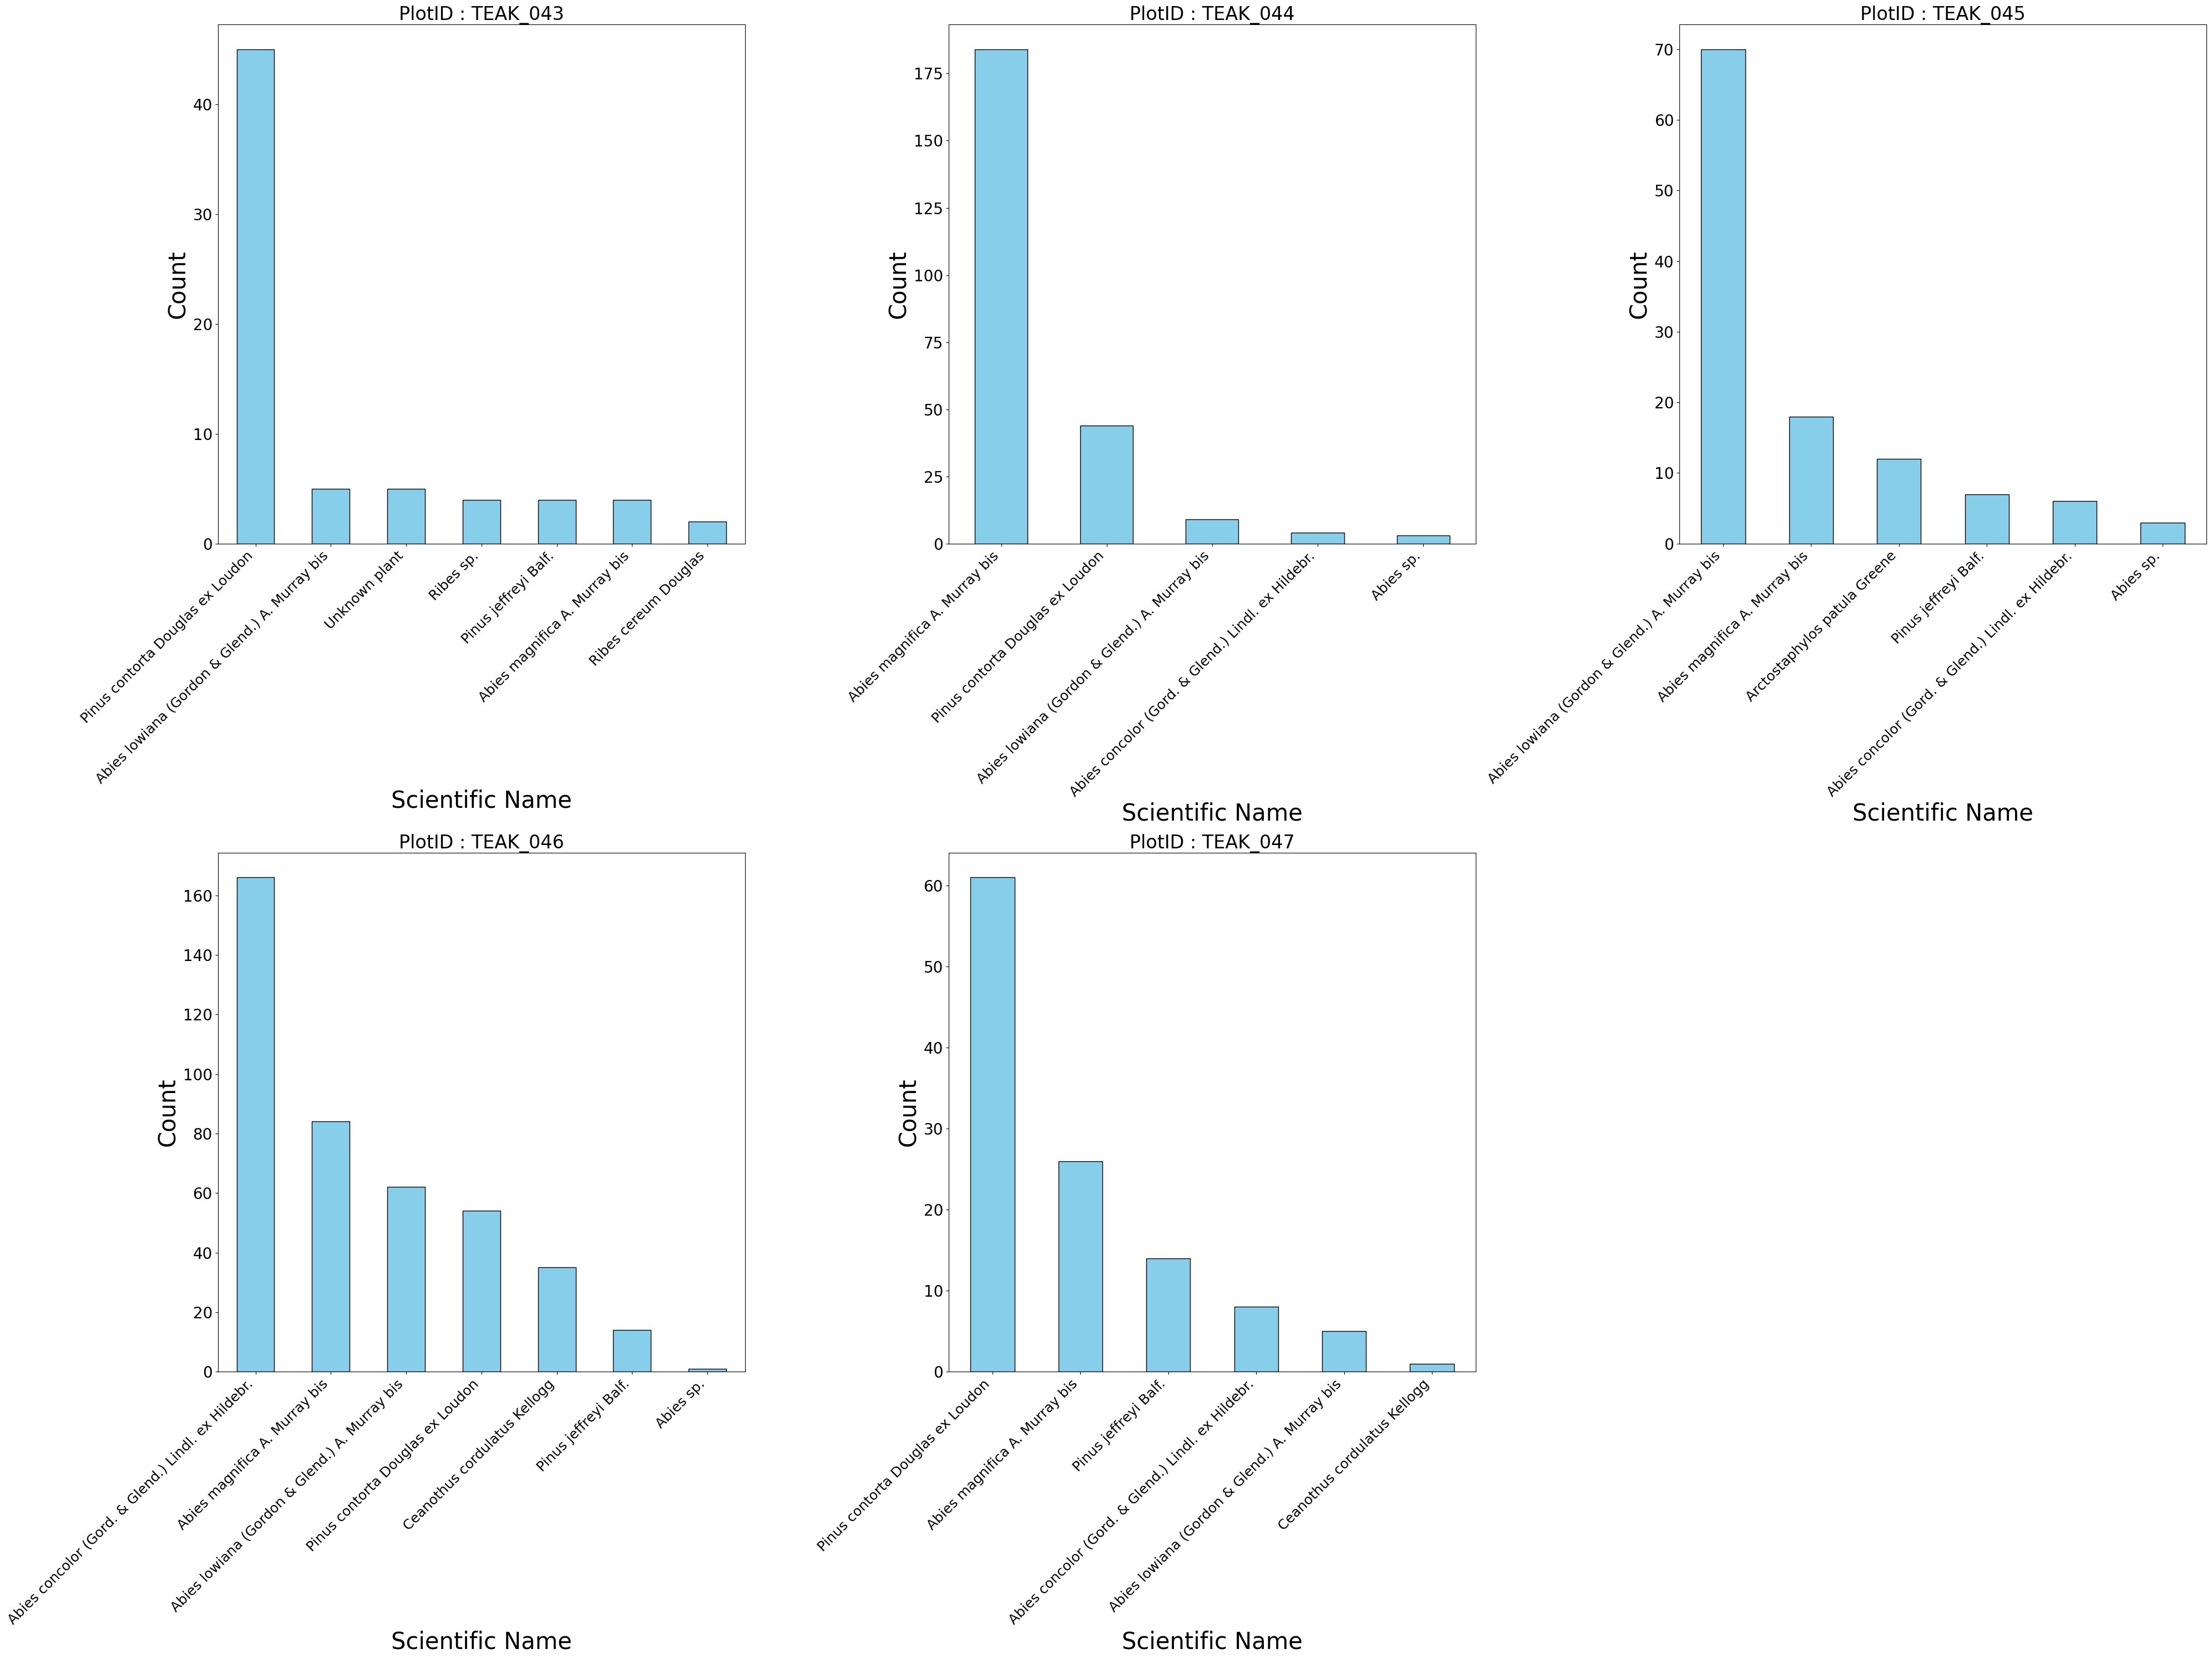

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

root_path = 'C:/Users/allen/OneDrive/Desktop/Work/Scripts/Tree Segmentation/output/'

map_tag = pd.read_csv("C:/Users/allen/OneDrive/Desktop/Work/data/Tree Segmentation/TEAK/NEON_struct-plant/TEAK_maptag_allyears_2022.csv")

subset = ['TEAK_043', 'TEAK_044', 'TEAK_045', 'TEAK_046', 'TEAK_047']
new_map_tag = map_tag[map_tag['plotID'].isin(subset)]
new_map_tag.sort_values(by='plotID', inplace=True)
unique_plots = new_map_tag['plotID'].unique()

plt.rcParams['axes.titlesize'] = 24
plt.rcParams['axes.labelsize'] = 30
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 20

figs, axs = plt.subplots(2, 3, figsize = (40, 30))
figs.delaxes(axs[1, 2])

for i, plot_id in enumerate(unique_plots):
    plot_df = new_map_tag[new_map_tag['plotID'] == plot_id]
    
    # Count occurrences of each species for current plotID
    species_counts = plot_df['scientificName'].value_counts()
    
    # Plot bar chart for current plotID
    row = i // 3  # Calculate the row index
    col = i % 3   # Calculate the column index
    species_counts.plot(kind='bar', ax=axs[row, col], color='skyblue', edgecolor='black')
    axs[row, col].set_title(f'PlotID : {plot_id}')
    axs[row, col].set_xlabel('Scientific Name')
    axs[row, col].set_ylabel('Count')
    axs[row, col].set_xticks(range(len(species_counts)))
    axs[row, col].set_xticklabels(species_counts.index, rotation=45, ha='right')  # Rotate x-axis labels


plt.tight_layout()
plt.show()

figs.savefig(root_path + 'TEAK_043_to_047_species.png')

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

with_shrub_path = 'C:/Users/allen/OneDrive/Desktop/Work/Scripts/Tree Segmentation/output/with_shrub/'
without_shrub_path = 'C:/Users/allen/OneDrive/Desktop/Work/Scripts/Tree Segmentation/output/without_shrub/'
root_path = 'C:/Users/allen/OneDrive/Desktop/Work/Scripts/Tree Segmentation/output/'


app_indv = pd.read_csv("C:/Users/allen/OneDrive/Desktop/Work/data/Tree Segmentation/TEAK/NEON_struct-plant/TEAK_appindv_allyears_2022.csv")
print(len(app_indv))

most_recent_df = app_indv[app_indv['date'].str.contains('2015') == False]
most_recent_df = most_recent_df[most_recent_df['growthForm'].str.contains('shrub') == False]
duplicate_mask_with_2015 = most_recent_df.duplicated(subset = 'individualID', keep = False)
duplicates_2015 = most_recent_df[duplicate_mask_with_2015]

duplicates_2015.sort_values(by = ['individualID', 'plotID', 'date'], inplace=True)

# duplicate_mask_with_2015 = duplicates_2015.duplicated(subset = 'individualID', keep = False)
# duplicates_2015 = duplicates_2015[duplicate_mask_with_2015]

pd.set_option('display.expand_frame_repr', False)
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(duplicates_2015[[ 'plotID', 'individualID', 'date']])

print (len(duplicates_2015))

filtered_df = app_indv.drop_duplicates(subset = 'individualID')

most_recent_df = filtered_df[filtered_df['date'].str.contains('2015') == False]
print(len(filtered_df))
print(len(duplicates_2015))

5062
        plotID              individualID        date
3100  TEAK_045   NEON.PLA.D17.TEAK.00307  2021-11-22
3657  TEAK_045   NEON.PLA.D17.TEAK.00307  2022-07-13
3059  TEAK_045   NEON.PLA.D17.TEAK.00308  2021-11-22
3784  TEAK_045   NEON.PLA.D17.TEAK.00308  2022-07-13
3118  TEAK_045   NEON.PLA.D17.TEAK.00309  2021-11-22
3788  TEAK_045   NEON.PLA.D17.TEAK.00309  2022-07-13
3060  TEAK_045   NEON.PLA.D17.TEAK.00313  2021-11-22
3850  TEAK_045   NEON.PLA.D17.TEAK.00313  2022-07-13
3024  TEAK_045   NEON.PLA.D17.TEAK.00314  2021-11-22
3674  TEAK_045   NEON.PLA.D17.TEAK.00314  2022-07-13
3048  TEAK_045   NEON.PLA.D17.TEAK.00315  2021-11-22
3652  TEAK_045   NEON.PLA.D17.TEAK.00315  2022-07-13
3077  TEAK_045   NEON.PLA.D17.TEAK.00317  2021-11-22
3814  TEAK_045   NEON.PLA.D17.TEAK.00317  2022-07-13
3123  TEAK_045   NEON.PLA.D17.TEAK.00318  2021-11-22
3812  TEAK_045   NEON.PLA.D17.TEAK.00318  2022-07-13
3069  TEAK_045   NEON.PLA.D17.TEAK.00319  2021-11-22
3776  TEAK_045   NEON.PLA.D17.TEAK.00319 

C:\Users\allen\AppData\Local\Temp\ipykernel_16768\962613253.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  duplicates_2015.sort_values(by = ['individualID', 'plotID', 'date'], inplace=True)
